# Trabajo Práctico: Predicción de lluvia en Australia

Objetivo: predicción de  ‘RainTomorrow’ (si el día siguiente llueve o no llueve, problema de Clasificación) y ‘RainfallTomorrow’ (cantidad de lluvia del día posterior a la observación, problema de Regresión. en función del resto de las características que se consideren adecuadas.
La columna ‘Location’ indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

## Primeros pasos:

Importacion de librerias:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc # roc_auc_scor -> area bajo la curva

Carga de datos del dataset:

Contiene información climática de Australia de los últimos diez años.

In [ ]:
df_weather = pd.read_csv('weatherAUS.csv', sep=',',engine='python')

Se pueden ver muchos NaN en diferentes variables, algunos tipos de datos mal cargados, una variable que no representa nada (Unnamed: 0).
Son 145412 filas pero hay que tener en cuenta que debemos eliminar algunas correspondientes a las localidades que no nos interesan para nuestro problema.

In [ ]:
# Informacion general sobre el dataset
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [ ]:
# Vista rapida de los datos
df_weather.head(10)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
5,5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,...,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No,0.0
6,6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,...,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No,0.0
7,7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,...,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No,0.0
8,8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,...,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes,1.4
9,9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,...,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No,0.0


## Limpieza general del dataset:

Eliminamos la columna 'Unnamed: 0' que aparentemente es un indice viejo y no nos aportaria nada

In [ ]:
df_weather.drop('Unnamed: 0', axis=1, inplace=True)

Ajuste de tipo de datos de columnas mal cargados

In [ ]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

Cantidad de valores NaN por columna

In [ ]:
df_weather.isna().sum()

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

Porcentaje de valores faltantes por columna

In [ ]:
porcentaje_faltantes = (df_weather.isna().sum() / len(df_weather)) * 100

porcentaje_faltantes.round(2)

Date                 0.00
Location             0.00
MinTemp              1.02
MaxTemp              0.86
Rainfall             2.24
Evaporation         43.16
Sunshine            48.00
WindGustDir          7.09
WindGustSpeed        7.05
WindDir9am           7.26
WindDir3pm           2.91
WindSpeed9am         1.22
WindSpeed3pm         2.11
Humidity9am          1.82
Humidity3pm          3.10
Pressure9am         10.36
Pressure3pm         10.33
Cloud9am            38.42
Cloud3pm            40.81
Temp9am              1.21
Temp3pm              2.48
RainToday            2.24
RainTomorrow         2.24
RainfallTomorrow     2.24
dtype: float64

Se puede observar que hay demasiados valor NaN por columna. Hay que tener en cuenta que aun restan eliminar las localidades que no se van a utilizar para la regresion.

### Imputacion de localidades con aeropuerto de la localidad y viceversa:

Una buena primera aproximacion a completar los valores NaN es debido a la proximidad geografica imputar los valores de cada localidad (de las que vamos a utilizar) con su respectivo aeropuerto y viceversa, y ver ahi como quedan los NaN

In [ ]:
def completar_localidad_aeropuerto(localidad):

  ''' Funcion que completa los valores NaN de una localidad con su aeropuerto y viceversa'''

  if localidad[-7:] == 'Airport':
    localidad_2 = localidad[:-7]
  else:
    localidad_2 = localidad+'Airport'

  columnas = df_weather.columns[2:]

  for columna in columnas:

    # Filtro para obtener las filas de localidad donde la columna sea NaN
    filtro_01 = (df_weather['Location'] == localidad) & (df_weather[columna].isna())

    # Aplico el filtro y me quedo con las fechas de la localidad donde la columna es NaN
    # para luego buscar por esa fecha pero en la localidad que si contiene los datos
    localidad_nan = df_weather[filtro_01]['Date']

    # Filtro que busca en las filas de la localidad que contiene los datos completos en las fechas que se necesitan
    filtro_02 = (df_weather['Location'] == localidad_2) & (df_weather['Date'].isin(localidad_nan))

    # Aplicamos el filtro anterior y obtenemos las fechas que contienen datos con los que completaremos
    fechas_not_nan = df_weather.loc[filtro_02, 'Date']

    # Nuevo filtro que busca la localidad que queremos completar donde los datos sean NaN y ademas las fechas se correspondan
    # con fechas donde tenemos datos para completar
    filtro_03 = (df_weather['Location'] == localidad) & (df_weather[columna].isna() & df_weather['Date'].isin(fechas_not_nan))

    # Completamos los valores de nuestra localidad con los de la otra
    df_weather.loc[filtro_03, columna] = df_weather.loc[filtro_02, columna].values

Utilizamos la funcion anterior localidad por localidad (con Canberra no nos hara nada ya que dicho aeropuerto no existe en el df)

In [ ]:
localidades = ["Sydney", "SydneyAirport", "Melbourne", "MelbourneAirport"]

for localidad in localidades:
  completar_localidad_aeropuerto(localidad)

### Imputacion con resto de localidades cercanas:

Teniendo en cuenta que a los fines del trabajo practico (segun la consigna) ["Sydney", "SydneyAirport", "Canberra", "Melbourne", "MelbourneAirport"] se pueden considerar como una unica localidad, ahora se puede intentar rellenar los NaN con los valores de localidades cercanas a estas:

Vemos que tenemos a una distancia de:

- 21.7 km a Tuggeranong (de Canberra)
- 50 km a Penrith (de Sydney)

In [ ]:
localidades_cercanas = ['Tuggeranong', 'Penrith']

columnas = df_weather.columns

for localidad in localidades:
  for localidad_cercana in localidades_cercanas:
    for columna in columnas:

        # Filtro para obtener las filas de localidad donde la columna sea NaN
        filtro_01 = (df_weather['Location'] == localidad) & (df_weather[columna].isna())

        # Aplico el filtro y me quedo con las fechas de la localidad donde la columna es NaN
        # para luego buscar por esa fecha pero en la localidad que si contiene los datos
        localidad_nan = df_weather[filtro_01]['Date']

        # Filtro que busca en las filas de la localidad que contiene los datos completos en las fechas que se necesitan
        filtro_02 = (df_weather['Location'] == localidad_cercana) & (df_weather['Date'].isin(localidad_nan))

        # Aplicamos el filtro anterior y obtenemos las fechas que contienen datos con los que completaremos
        fechas_not_nan = df_weather.loc[filtro_02, 'Date']

        # Nuevo filtro que busca la localidad que queremos completar donde los datos sean NaN y ademas las fechas se correspondan
        # con fechas donde tenemos datos para completar
        filtro_03 = (df_weather['Location'] == localidad) & (df_weather[columna].isna() & df_weather['Date'].isin(fechas_not_nan))

        # Completamos los valores de nuestra localidad con los de la otra
        df_weather.loc[filtro_03, columna] = df_weather.loc[filtro_02, columna].values

### Nos quedamos solo con las localidades que nos interesan en nuestro objetivo

In [ ]:
# Lista de lugares a mantener
lugares_deseados = ["Sydney", "SydneyAirport", "Canberra", "Melbourne", "MelbourneAirport"]

# Filtrar el DataFrame
df_weather = df_weather[df_weather["Location"].isin(lugares_deseados)]

### Primera seleccion de caracteristicas basandose en la matriz de correlacion:

El objetivo de esta primera seleccion de caracteristicas es evitar lo mas posible eliminar filas que contengan NaN. Por este motivo se evalua que caracteristicas tienen una baja correlacion con la variable independiente y de las que quedan cuales tienen una alta correlacion entre si.

<ipython-input-13-79fa7190bcaa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_weather.corr()


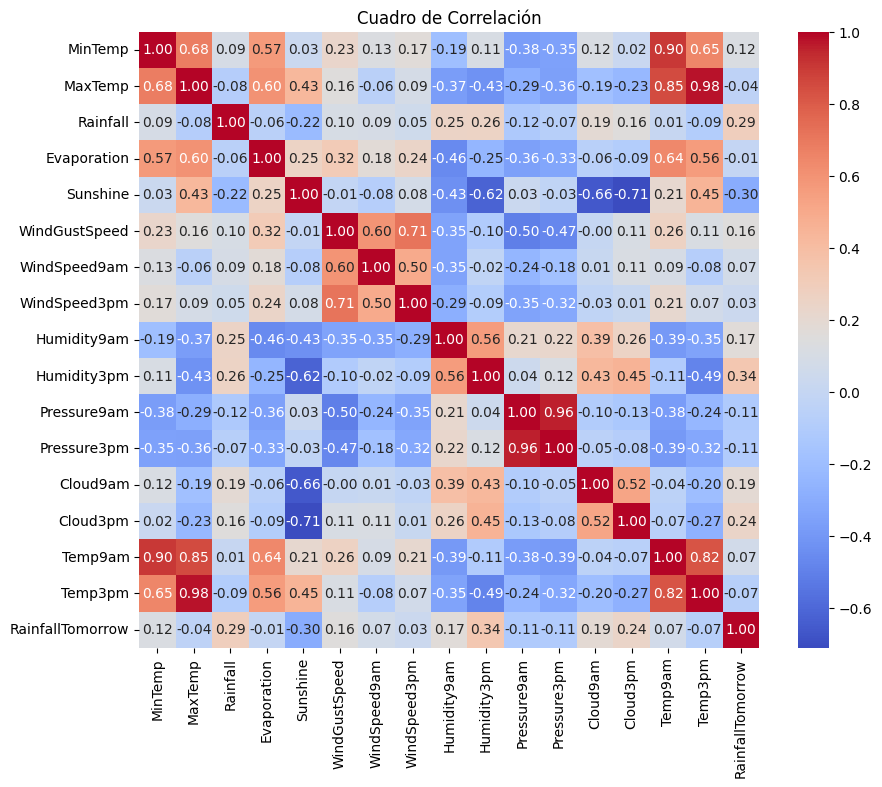

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = df_weather.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea un mapa de calor con seaborn para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añade un título al cuadro de correlación
plt.title("Cuadro de Correlación")

# Muestra el cuadro de correlación
plt.show()

#### Caracteresticas que tienen una muy baja correlacion con nuestra variable dependiente 'RainfallTomorrow':

- 'MaxTemp': -0.04
- 'Evaporation': -0.04
- 'WindSpeed3pm':  0.05
- 'Temp9am': 0.05

In [ ]:
df_weather.drop('MaxTemp', axis=1, inplace=True)
df_weather.drop('Evaporation', axis=1, inplace=True)
df_weather.drop('WindSpeed3pm', axis=1, inplace=True)
df_weather.drop('Temp9am', axis=1, inplace=True)

#### 'Sunshine' tiene una correlacion grande con 'Cloud3pm', -0.7. Ademas tiene un gran porcentaje de valores NaN. En caso de considerarlas para la regresion lineal tendriamos que quitar una de las dos. Ambas tienen una correlacion similar con la variable dependiente. Por la cuestion de los nulos se prefiere conservar la segunda.

In [ ]:
df_weather.drop('Sunshine', axis=1, inplace=True)

#### 'WindGustDir', 'WindDir9am' y 'WindDir3pm' representan la direccion del viento. La que mas nos interesa conservar es la ultima registrada. Por lo tanto quitamos el resto de columnas

In [ ]:
df_weather.drop(['WindGustDir', 'WindDir9am'], axis=1, inplace=True)

#### 'Cloud3pm' y 'Cloud9am':

'Cloud9am' y 'Cloud3pm' representan la nubosidad en distintos momentos y no pareceria tener demasiado sentido meter a ambas en nuestro analisis. Ademas tienen algo de correlacion lineal entre ellas (0.5).

Se evalua grafico de puntos en una localidad en toda la serie, durante un año y durante un mismo mes para evaluar comportamiento de la misma que pueda justificar algun tipo de imputacion por medida resumen en una ventana de determinada cantidad de dias o una interpolacion

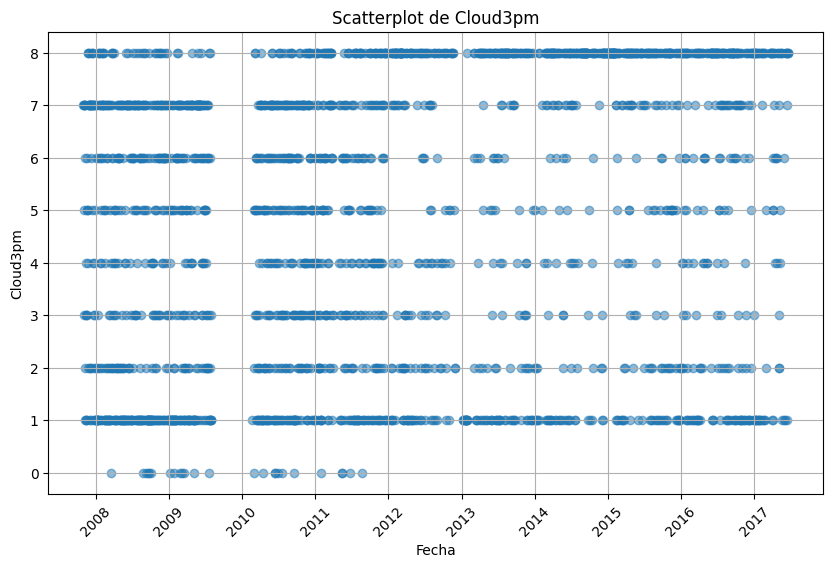

In [ ]:
cloud3pm = df_weather[ df_weather['Location'] == 'Canberra' ][['Date', 'Cloud3pm']]

plt.figure(figsize=(10, 6))
plt.scatter(cloud3pm['Date'], cloud3pm['Cloud3pm'], alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Cloud3pm')
plt.title('Scatterplot de Cloud3pm')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

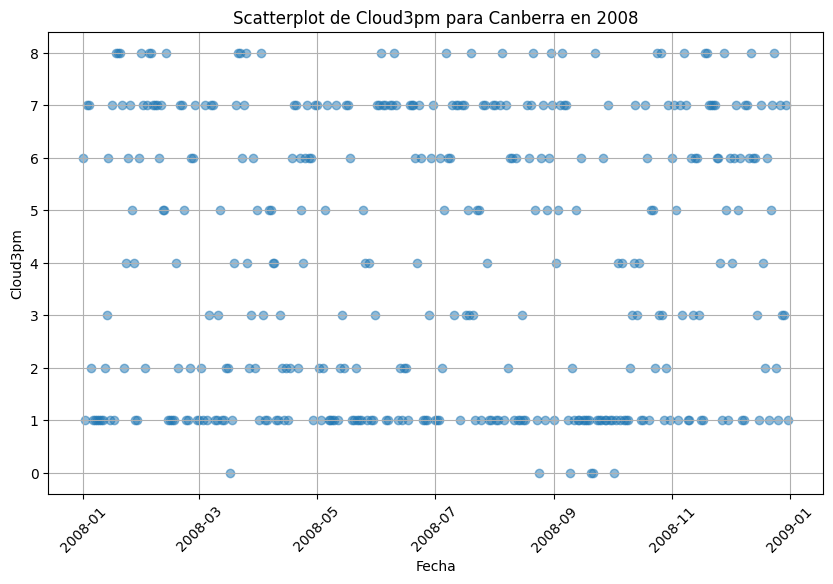

In [ ]:
cloud3pm_2008 = df_weather[(df_weather['Location'] == 'Canberra') & (df_weather['Date'].dt.year == 2008)][['Date', 'Cloud3pm']]

plt.figure(figsize=(10, 6))
plt.scatter(cloud3pm_2008['Date'], cloud3pm_2008['Cloud3pm'], alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Cloud3pm')
plt.title('Scatterplot de Cloud3pm para Canberra en 2008')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

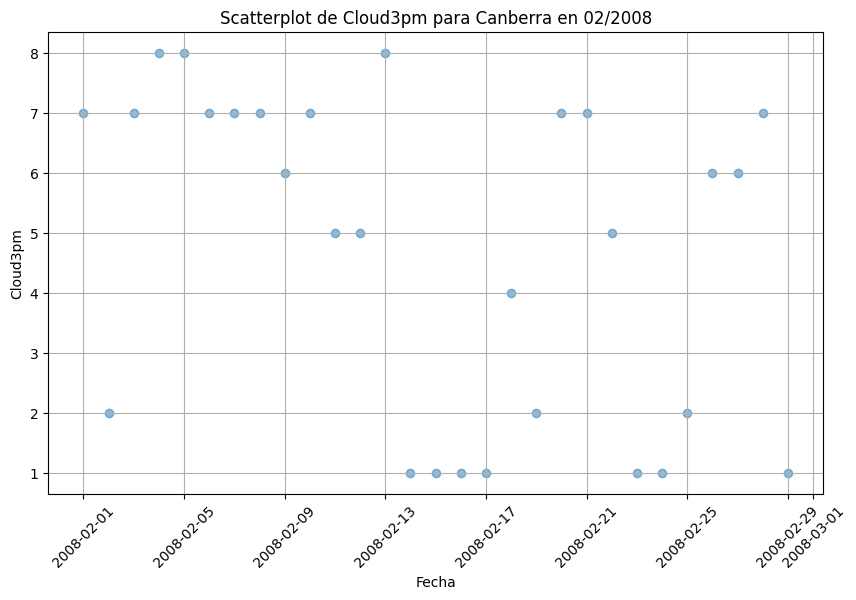

In [ ]:
cloud3pm_2008 = df_weather[(df_weather['Location'] == 'Canberra') & (df_weather['Date'].dt.year == 2008) & (df_weather['Date'].dt.month == 2)][['Date', 'Cloud3pm']]

plt.figure(figsize=(10, 6))
plt.scatter(cloud3pm_2008['Date'], cloud3pm_2008['Cloud3pm'], alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Cloud3pm')
plt.title('Scatterplot de Cloud3pm para Canberra en 02/2008')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

La variable no parece mostrar algun comportamiento detectable con nuestros conocimientos se descarta la posibilidad de imputar por medida resumen o de interpolacion lineal. Se prefiere evitar eliminar los NaN. Se opta por completar en la medida de lo posible con los datos de la nubosidad de las 9am si esta disponible


In [ ]:
def rellenar_entre_columnas(localidad, columna_01, columna_02):

  ''' Funcion que rellena los valores NaN de una columna con los
      valores de otra de la misma fecha y localidad'''

  filtro_01 = ( (df_weather[columna_01].isna()) & (df_weather['Location']==localidad) )

  fechas = df_weather.loc[ filtro_01, 'Date' ]

  filtro_02 = df_weather['Date'].isin(fechas) & (df_weather['Location']==localidad)

  df_weather.loc[ filtro_02, columna_01 ] = df_weather.loc[ filtro_02 , columna_02 ]


In [ ]:
for localidad in lugares_deseados:
  rellenar_entre_columnas(localidad, 'Cloud3pm', 'Cloud9am')

In [ ]:
df_weather.drop('Cloud9am', axis=1, inplace=True)

#### 'WindGustSpeed' y 'WindSpeed9am' representan lo mismo en diferentes momentos del dia, tienen una correlacion bastante significativa, 0.6. Se determina quedarnos con 'WindSpeed9am' debido a que la otra contiene una cantidad significativa de NaN y al problema que resulta conseguir los datos. Pero antes si es posible se completan los valores faltantes de una con la otra.

In [ ]:
for localidad in lugares_deseados:
  rellenar_entre_columnas(localidad, 'WindSpeed9am', 'WindGustSpeed')

In [ ]:
df_weather.drop('WindGustSpeed', axis=1, inplace=True)

#### Nuevamente lo mismo para 'Pressure9am' y 'Pressure3pm'. Representan lo mismo a diferentes horas. Ambas tienen una correlacion baja con la variable independiente. Tomar ambas complejizaria el modelo, se determina quedarnos con la mas actual.

In [ ]:
for localidad in lugares_deseados:
  rellenar_entre_columnas(localidad, 'Pressure3pm', 'Pressure9am')

In [ ]:
df_weather.drop('Pressure9am', axis=1, inplace=True)

#### Mismo caso con 'Humidity9am' y 'Humidity3pm' con bastante correlacion entre si, 0.56. Se determina quedarnos con la ultima.

Primero se evalua si algun otro tipo de imputacion tiene sentido

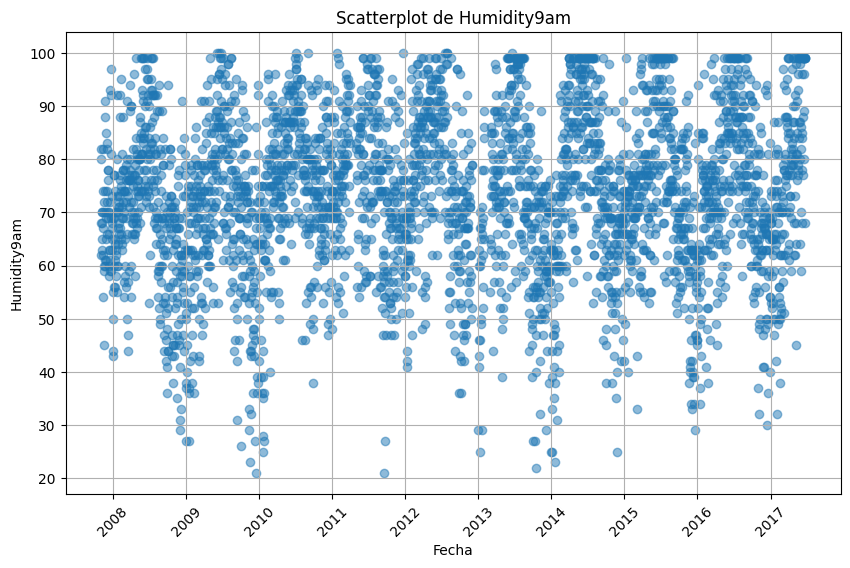

In [ ]:
humidity9am = df_weather[ df_weather['Location'] == 'Canberra' ][['Date', 'Humidity9am']]

plt.figure(figsize=(10, 6))
plt.scatter(humidity9am['Date'], humidity9am['Humidity9am'], alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Humidity9am')
plt.title('Scatterplot de Humidity9am')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

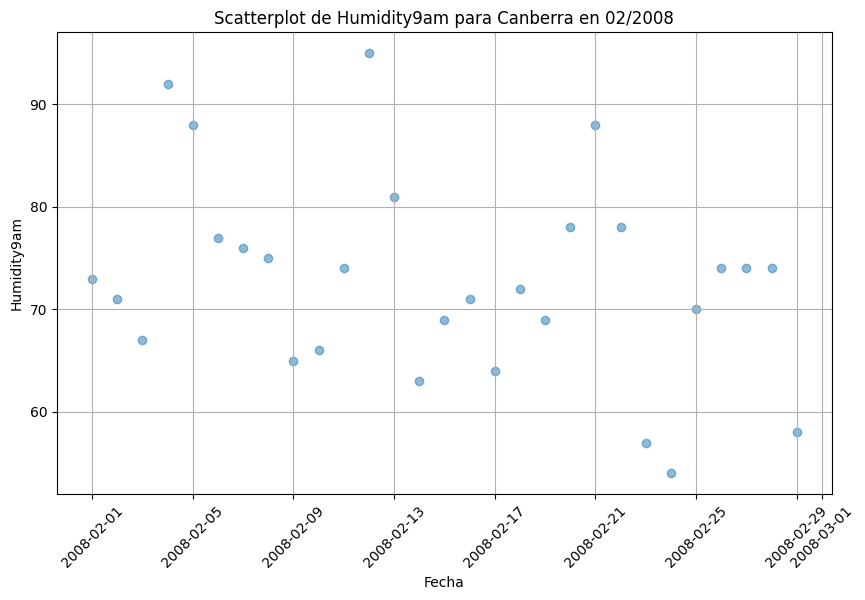

In [ ]:
humidity9am_2008 = df_weather[(df_weather['Location'] == 'Canberra') & (df_weather['Date'].dt.year == 2008) & (df_weather['Date'].dt.month == 2)][['Date', 'Humidity9am']]

plt.figure(figsize=(10, 6))
plt.scatter(humidity9am_2008['Date'], humidity9am_2008['Humidity9am'], alpha=0.5)
plt.xlabel('Fecha')
plt.ylabel('Humidity9am')
plt.title('Scatterplot de Humidity9am para Canberra en 02/2008')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

No parece verse ningun comportamiento a simple vista que justifique una imputacion por valor resumen o interpolacion lineal. Se completan los valores de una columna con la otra.

In [ ]:
for localidad in lugares_deseados:
  rellenar_entre_columnas(localidad, 'Humidity3pm', 'Humidity9am')

In [ ]:
df_weather.drop('Humidity9am', axis=1, inplace=True)

#### Alta correlacion entre 'MinTemp' y 'Temp3pm' (0.65) por lo que se escoge la que mayor correlacion tiene con la variable independiente.

In [ ]:
df_weather.drop('Temp3pm', axis=1, inplace=True)

#### Resto de NaN:

Actualizacion de cantidad de valores NaN por columna

In [ ]:
df_weather.isna().sum()

Date                  0
Location              0
MinTemp               6
Rainfall             18
WindDir3pm          231
WindSpeed9am        216
Humidity3pm           3
Pressure3pm         214
Cloud3pm            779
RainToday            18
RainTomorrow         18
RainfallTomorrow     18
dtype: int64

In [ ]:
# Calcular el porcentaje de valores faltantes por columna
porcentaje_faltantes = (df_weather.isna().sum() / len(df_weather)) * 100

porcentaje_faltantes.round(2)

Date                0.00
Location            0.00
MinTemp             0.04
Rainfall            0.11
WindDir3pm          1.45
WindSpeed9am        1.35
Humidity3pm         0.02
Pressure3pm         1.34
Cloud3pm            4.87
RainToday           0.11
RainTomorrow        0.11
RainfallTomorrow    0.11
dtype: float64

In [ ]:
print(f'Cantidad de filas: {df_weather.shape[0]}')

Cantidad de filas: 15986


Quedan muy pocos datos para limpiar, eliminarlos no va a suponer una gran diferencia.

In [ ]:
df_weather = df_weather.dropna()

In [ ]:
df_weather.reset_index(drop=True, inplace=True)

In [ ]:
print(f'Cantidad de filas: {df_weather.shape[0]}')

Cantidad de filas: 15160


#### Resumen general de la limpieza:

Antes de la limpieza teniamos: 15986 filas.

Al finalizar la limpieza nos quedaron: 15160 filas.

Es decir, se perdió aproximadamente el 5% de los datos en el proceso.

Cantidad de filas actual por 'Location':

In [ ]:
df_weather.groupby('Location').size()

Location
Canberra            2612
Melbourne           3192
MelbourneAirport    3008
Sydney              3340
SydneyAirport       3008
dtype: int64

Al parecer Canberra fue la localidad mas afectada.

En cuanto a localidades el dataset nos quedo desbalanceado, pero la consigna dice que podemos tomar todo como una misma localidad.

### Verificacion de carga de datos en variables categoricas:

In [ ]:
df_weather.columns

Index(['Date', 'Location', 'MinTemp', 'Rainfall', 'WindDir3pm', 'WindSpeed9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'RainTomorrow',
       'RainfallTomorrow'],
      dtype='object')

Verificamos los datos categoricos para detectar cargas erroneas, *por ej: en el caso de df_weather['WindDir3pm'] que 'SE' no este cargado tambien como 'se' ya que no estariamos hablando de lo mismo en ese caso*.

In [ ]:
df_weather['Location'].unique()

array(['Sydney', 'SydneyAirport', 'Canberra', 'MelbourneAirport',
       'Melbourne'], dtype=object)

In [ ]:
df_weather['WindDir3pm'].unique()

array(['SSW', 'E', 'ESE', 'W', 'ENE', 'S', 'SE', 'SSE', 'NE', 'NNE',
       'NNW', 'NW', 'WNW', 'N', 'WSW', 'SW'], dtype=object)

In [ ]:
df_weather['RainToday'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
# Codificacion de 'RainToday':
df_weather['RainToday'] = df_weather['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df_weather['RainTomorrow'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
# Codificacion de 'RainTomorrow': Llueve es la clase positiva (1), No llueve es la clase negativa (0)
df_weather['RainTomorrow'] = df_weather['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

No se encontraron datos de una misma categoria en ninguna de las columnas cargados de manera ambigua

In [ ]:
df_weather.reset_index(drop=True, inplace=True)

## 2. Analisis descriptivo:

Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada una de las variables involucradas en el problema detallando características, comportamiento y rango de variación.

Debe incluir:

● Análisis y decisión sobre datos faltantes

● Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)

● ¿Está balanceado el dataset?

● Codificación de variables categóricas (si se van a utilizar para predicción).

● Matriz de correlación

● Selección de características para la predicción.

● Estandarización de datos.

### Visualizacion de datos y medidas de resumen:

In [ ]:
df_weather.columns

Index(['Date', 'Location', 'MinTemp', 'Rainfall', 'WindDir3pm', 'WindSpeed9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'RainTomorrow',
       'RainfallTomorrow'],
      dtype='object')

In [ ]:
df_weather.head(10)

,Date,Location,MinTemp,Rainfall,WindDir3pm,WindSpeed9am,Humidity3pm,Pressure3pm,Cloud3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-02-01,Sydney,19.5,15.6,SSW,17.0,84.0,1017.4,8.0,1,1,6.0
1,2008-02-02,Sydney,19.5,6.0,E,9.0,73.0,1016.4,7.0,1,1,6.6
2,2008-02-03,Sydney,21.6,6.6,ESE,17.0,86.0,1015.6,8.0,1,1,18.8
3,2008-02-04,Sydney,20.2,18.8,E,22.0,90.0,1011.8,8.0,1,1,77.4
4,2008-02-05,Sydney,19.7,77.4,W,11.0,74.0,1004.8,8.0,1,1,1.6
5,2008-02-06,Sydney,20.2,1.6,ENE,9.0,62.0,998.6,6.0,1,1,6.2
6,2008-02-07,Sydney,18.6,6.2,S,15.0,80.0,1000.3,7.0,1,1,27.6
7,2008-02-08,Sydney,17.2,27.6,SE,7.0,61.0,1007.4,8.0,1,1,12.6
8,2008-02-09,Sydney,16.4,12.6,W,19.0,91.0,1007.6,7.0,1,1,8.8
9,2008-02-10,Sydney,14.6,8.8,SSE,11.0,53.0,1013.4,2.0,1,0,0.0


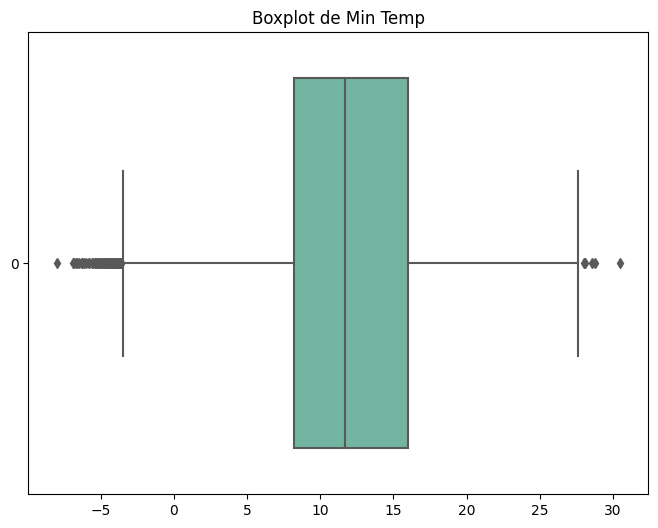

In [ ]:
# Crea una figura para el gráfico con un tamaño específico
plt.figure(figsize=(8, 6))

# Crea el boxplot horizontal utilizando seaborn
sns.boxplot(data=df_weather['MinTemp'], orient="h", palette="Set2")

# Establece el título del gráfico
plt.title("Boxplot de Min Temp")

# Muestra el gráfico
plt.show()

In [ ]:
df_weather['MinTemp'].describe()

count    15160.000000
mean        11.850759
std          5.654893
min         -8.000000
25%          8.200000
50%         11.700000
75%         16.000000
max         30.500000
Name: MinTemp, dtype: float64

Destaca la presencia de bastantes valores atipicos, pero esto puede deberse al analisis de las variables con todas las Localidades mezcladas.

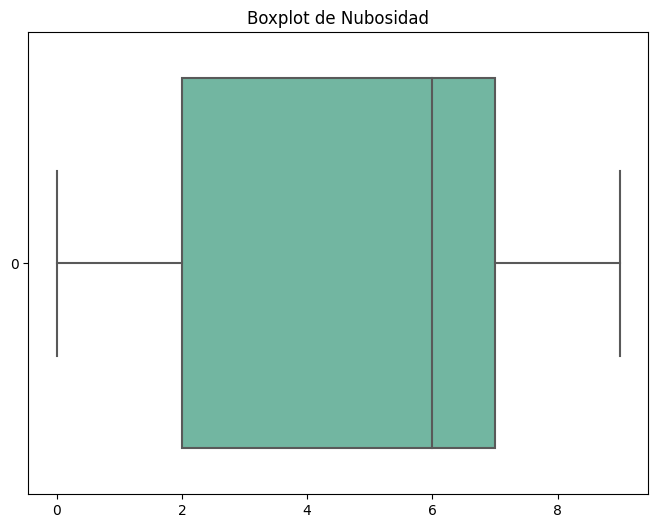

In [ ]:
nubosidad = df_weather.loc[:, 'Cloud3pm']
plt.figure(figsize=(8, 6))
sns.boxplot(data=nubosidad, orient="h", palette="Set2")
plt.title("Boxplot de Nubosidad")
plt.show()

In [ ]:
nubosidad.describe()

count    15160.000000
mean         4.767216
std          2.591393
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud3pm, dtype: float64

No hay valores atipicos hay mayor concentracion de datos en los valores mas chicos.

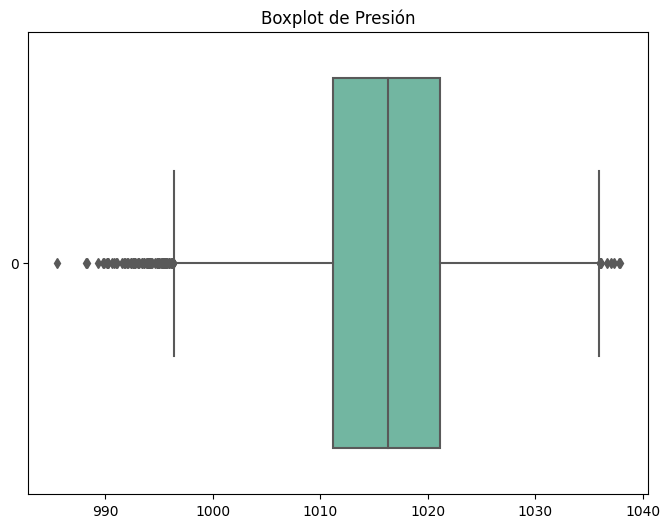

In [ ]:
presion = df_weather.loc[:, 'Pressure3pm']
plt.figure(figsize=(8, 6))
sns.boxplot(data=presion, orient="h", palette="Set2")
plt.title("Boxplot de Presión")
plt.show()

In [ ]:
presion.describe()

count    15160.000000
mean      1016.094017
std          7.264083
min        985.500000
25%       1011.200000
50%       1016.300000
75%       1021.100000
max       1037.900000
Name: Pressure3pm, dtype: float64

Valores atipicos a la izquierda.

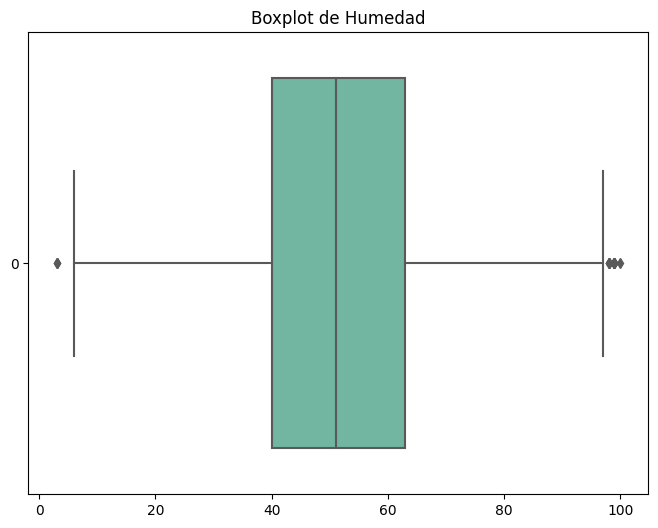

In [ ]:
humedad = df_weather.loc[ : , 'Humidity3pm']
plt.figure(figsize=(8, 6))
sns.boxplot(data=humedad, orient="h", palette="Set2")
plt.title("Boxplot de Humedad")
plt.show()

In [ ]:
humedad.describe()

count    15160.000000
mean        51.901253
std         17.541103
min          3.000000
25%         40.000000
50%         51.000000
75%         63.000000
max        100.000000
Name: Humidity3pm, dtype: float64

Pocos outliers, distribucion bastante simetrica.

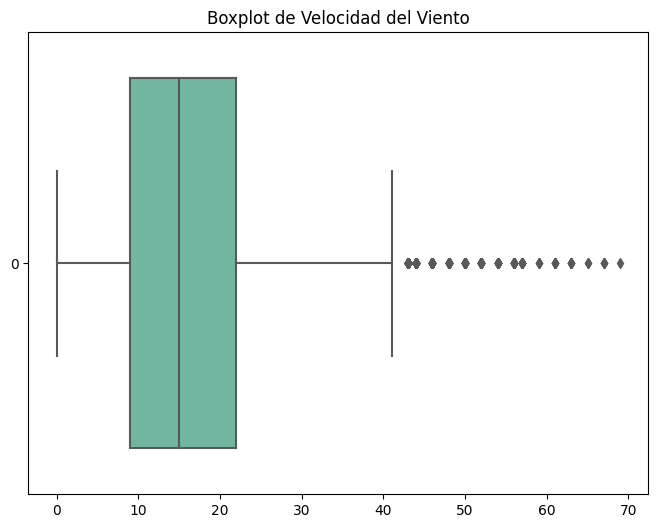

In [ ]:
viento_velocidad = df_weather.loc[ : , 'WindSpeed9am']
plt.figure(figsize=(8, 6))
sns.boxplot(data=viento_velocidad, orient="h", palette="Set2")
plt.title("Boxplot de Velocidad del Viento")
plt.show()

In [ ]:
viento_velocidad.describe()

count    15160.000000
mean        16.924934
std         10.337355
min          0.000000
25%          9.000000
50%         15.000000
75%         22.000000
max         69.000000
Name: WindSpeed9am, dtype: float64

Mucho valores atipicos a la derecha.

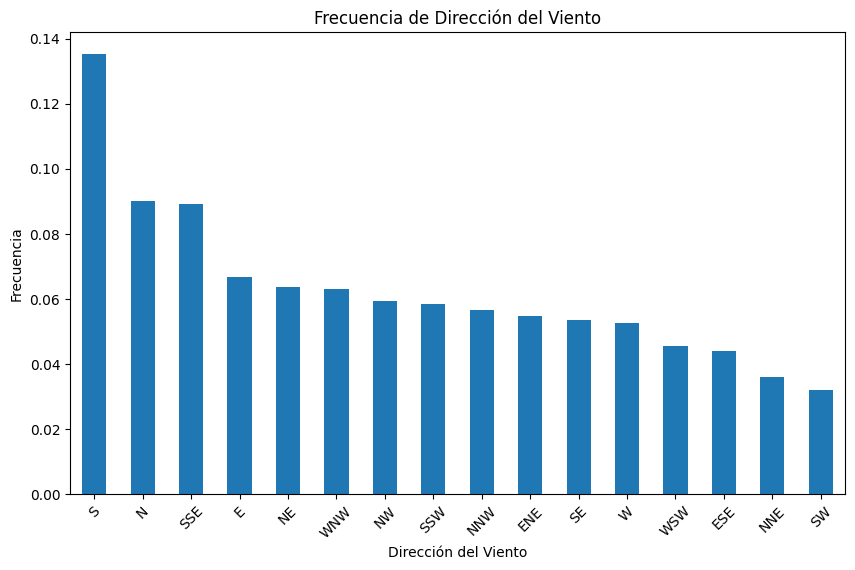

In [ ]:
viento_direccion = df_weather["WindDir3pm"]

# Calcular la frecuencia relativa de cada valor en la columna
frecuencia = viento_direccion.value_counts() / viento_direccion.shape[0]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
frecuencia.plot(kind="bar")
plt.title("Frecuencia de Dirección del Viento")
plt.xlabel("Dirección del Viento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

In [ ]:
viento_direccion.describe()

count     15160
unique       16
top           S
freq       2050
Name: WindDir3pm, dtype: object

En el total de las observaciones la moda es la direccion 'S' cuya frecuencia relativa es de casi 0.14.
En segundo lugar se encuentra el 'N' con 0.9 aproximadamente.

Vemos si existe alguna tendencia respecto a la dirección de los vientos del día anterior

In [ ]:
# Crear una tabla de frecuencias cruzadas
cross_table = pd.crosstab(index=df_weather['RainTomorrow'], columns=df_weather['WindDir3pm'], margins=True, normalize='index') * 100

# Redondear los valores a dos decimales
cross_table = cross_table.round(2)

# Renombrar las columnas para mayor claridad
cross_table.columns = [f"Percentage of {col}%" for col in cross_table.columns]

# Mostrar la tabla de frecuencias cruzadas con tabulate
print(tabulate(cross_table, headers='keys', tablefmt='pretty'))

+--------------+------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+
| RainTomorrow | Percentage of E% | Percentage of ENE% | Percentage of ESE% | Percentage of N% | Percentage of NE% | Percentage of NNE% | Percentage of NNW% | Percentage of NW% | Percentage of S% | Percentage of SE% | Percentage of SSE% | Percentage of SSW% | Percentage of SW% | Percentage of W% | Percentage of WNW% | Percentage of WSW% |
+--------------+------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------

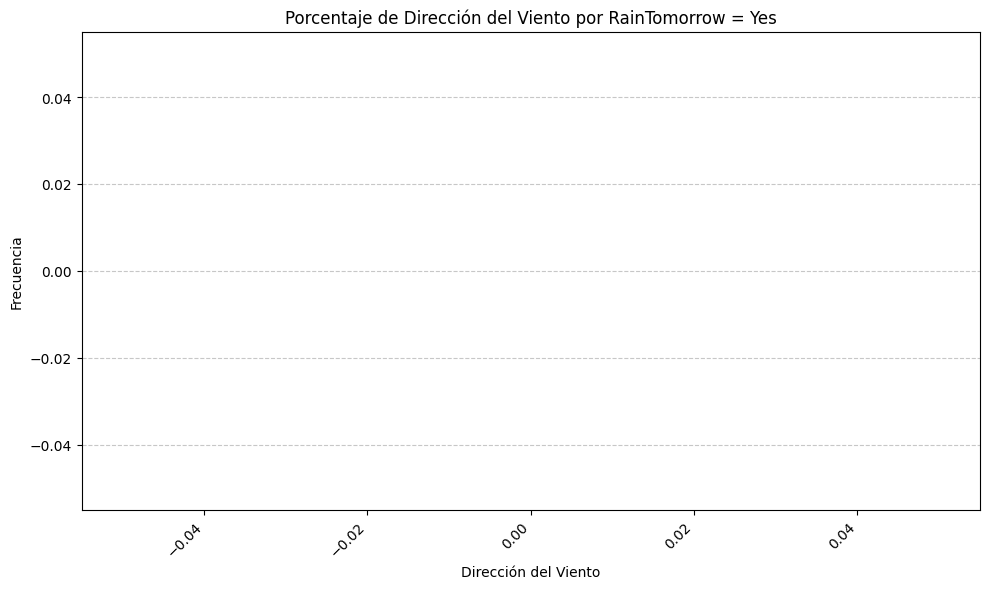

In [ ]:
# Filtrar los datos donde RainTomorrow es igual a 'Yes'
filtered_data = df_weather[df_weather['RainTomorrow'] == 'Yes']

# Calcular las frecuencias de cada dirección del viento
wind_direction_counts = filtered_data['WindDir3pm'].value_counts() / filtered_data['WindDir3pm'].shape[0]

# Ordenar las direcciones del viento por frecuencia (de mayor a menor)
wind_direction_counts = wind_direction_counts.sort_values(ascending=False)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(wind_direction_counts.index, wind_direction_counts.values)
plt.title("Porcentaje de Dirección del Viento por RainTomorrow = Yes")
plt.xlabel("Dirección del Viento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Por lo que indican las tablas de frecuencia, si bien los vientos S y N son los más usuales, la dirección SSW parece estar asociado con la posibilidad de lluvia.

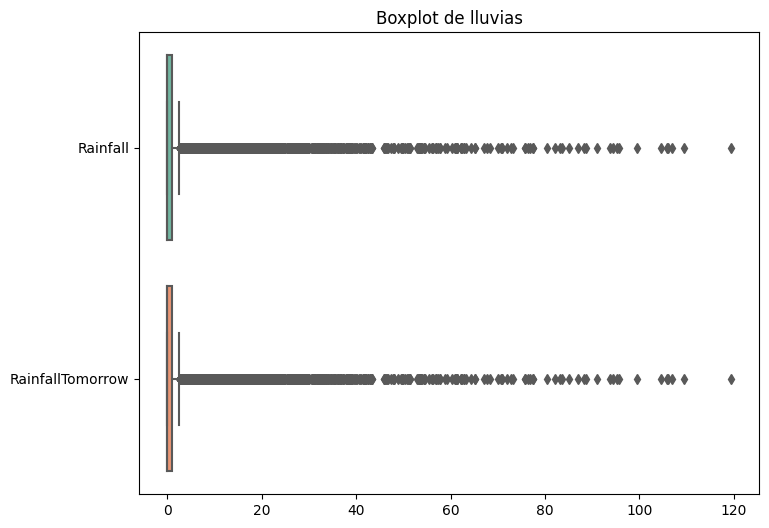

In [ ]:
lluvias = df_weather.loc[ : , ['Rainfall', 'RainfallTomorrow']]
plt.figure(figsize=(8, 6))
sns.boxplot(data=lluvias, orient="h", palette="Set2")
plt.title("Boxplot de lluvias")
plt.show()

Demasiada concentracion en los valores mas bajos que hace que todo el resto sea atipico

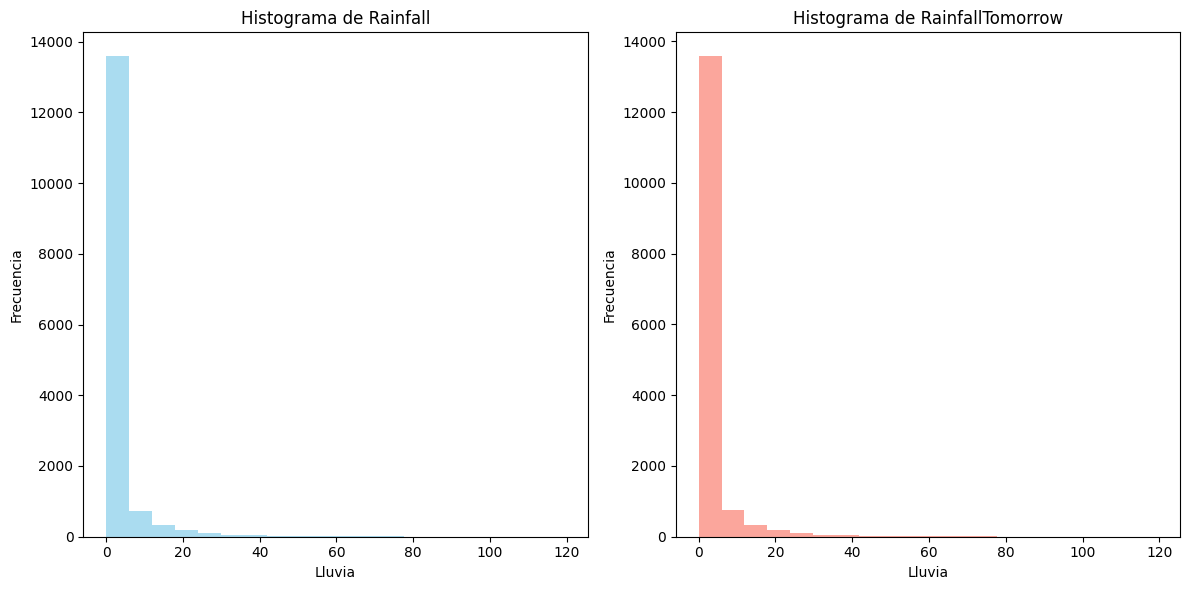

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear el primer histograma para la columna 4 (Temp9am)
plt.subplot(1, 2, 1)
plt.hist(lluvias.iloc[:, 0], bins=20, color='skyblue', alpha=0.7)
plt.title("Histograma de Rainfall")
plt.xlabel("Lluvia")
plt.ylabel("Frecuencia")

# Crear el segundo histograma para la última columna
plt.subplot(1, 2, 2)
plt.hist(lluvias.iloc[:, 1], bins=20, color='salmon', alpha=0.7)
plt.title("Histograma de RainfallTomorrow")
plt.xlabel("Lluvia")
plt.ylabel("Frecuencia")

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los histogramas
plt.show()

In [ ]:
lluvias.describe()

,Rainfall,RainfallTomorrow
count,15160.000000,15160.000000
mean,2.341807,2.343443
std,7.433138,7.435219
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,119.400000,119.400000


In [ ]:
# Calcular el porcentaje de "Rainfall" distinto de 0
porcentaje_rainfall = ((df_weather['Rainfall'] != 0).sum() / len(df_weather) * 100).round(2)

# Calcular el porcentaje de "RainfallTomorrow" distinto de 0
porcentaje_rainfall_tomorrow = ((df_weather['RainfallTomorrow'] != 0).sum() / len(df_weather) * 100).round(2)

print(f"Porcentaje de 'Rainfall' distinto de 0: {porcentaje_rainfall}%")
print(f"Porcentaje de 'RainfallTomorrow' distinto de 0: {porcentaje_rainfall_tomorrow}%")

Porcentaje de 'Rainfall' distinto de 0: 37.24%
Porcentaje de 'RainfallTomorrow' distinto de 0: 37.3%


In [ ]:
# Calcular el porcentaje de "YES" en la columna "RainTomorrow"
porcentaje_rain_tomorrow = (df_weather['RainTomorrow'].value_counts(normalize=True)[1] * 100).round(2)

# Calcular el porcentaje de "YES" en la columna "RainToday"
porcentaje_rain_today = (df_weather['RainToday'].value_counts(normalize=True)[1] * 100).round(2)

print(f"Porcentaje de 'YES' en RainTomorrow: {porcentaje_rain_tomorrow}%")
print(f"Porcentaje de 'YES' en RainToday: {porcentaje_rain_today}%")

Porcentaje de 'YES' en RainTomorrow: 24.03%
Porcentaje de 'YES' en RainToday: 23.98%


In [ ]:
# ¿Cual es el criterio de lluvia? Toma como lluvia = YES cuando la cantidad de Rainfall > 1, no cuando es mayor a 0, como podría pensarse

rainfall_may_0_y_menores_1 = (df_weather['Rainfall'] > 0) & (df_weather['Rainfall'] <= 1)
filtered_rows = df_weather[rainfall_may_0_y_menores_1]

### Codificar variable categórica

Ya que notamos cierta asociación de la dirección del viento SSW con la lluvia, codificamos su presencia

In [ ]:
# Crear una nueva columna 'WindDir3pm_S' con valores 1 si 'WindDir3pm' es igual a "S" y 0 en caso contrario
df_weather['WindDir3pm_SSW'] = (df_weather['WindDir3pm'] == "SSW").astype(int)

### ¿Esta balanceado el dataset?:

In [ ]:
df_weather['RainTomorrow'].value_counts().apply(lambda x: (x / df_weather.shape[0]) * 100 )

0    75.969657
1    24.030343
Name: RainTomorrow, dtype: float64

En cuanto al problema de clasificacion y a nuestra clase objetivo mas precisamente vemos que el dataset no esta balanceado

### Matriz de correlacion actualizada:

<ipython-input-71-bc6ba92dc0d4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_weather.corr()


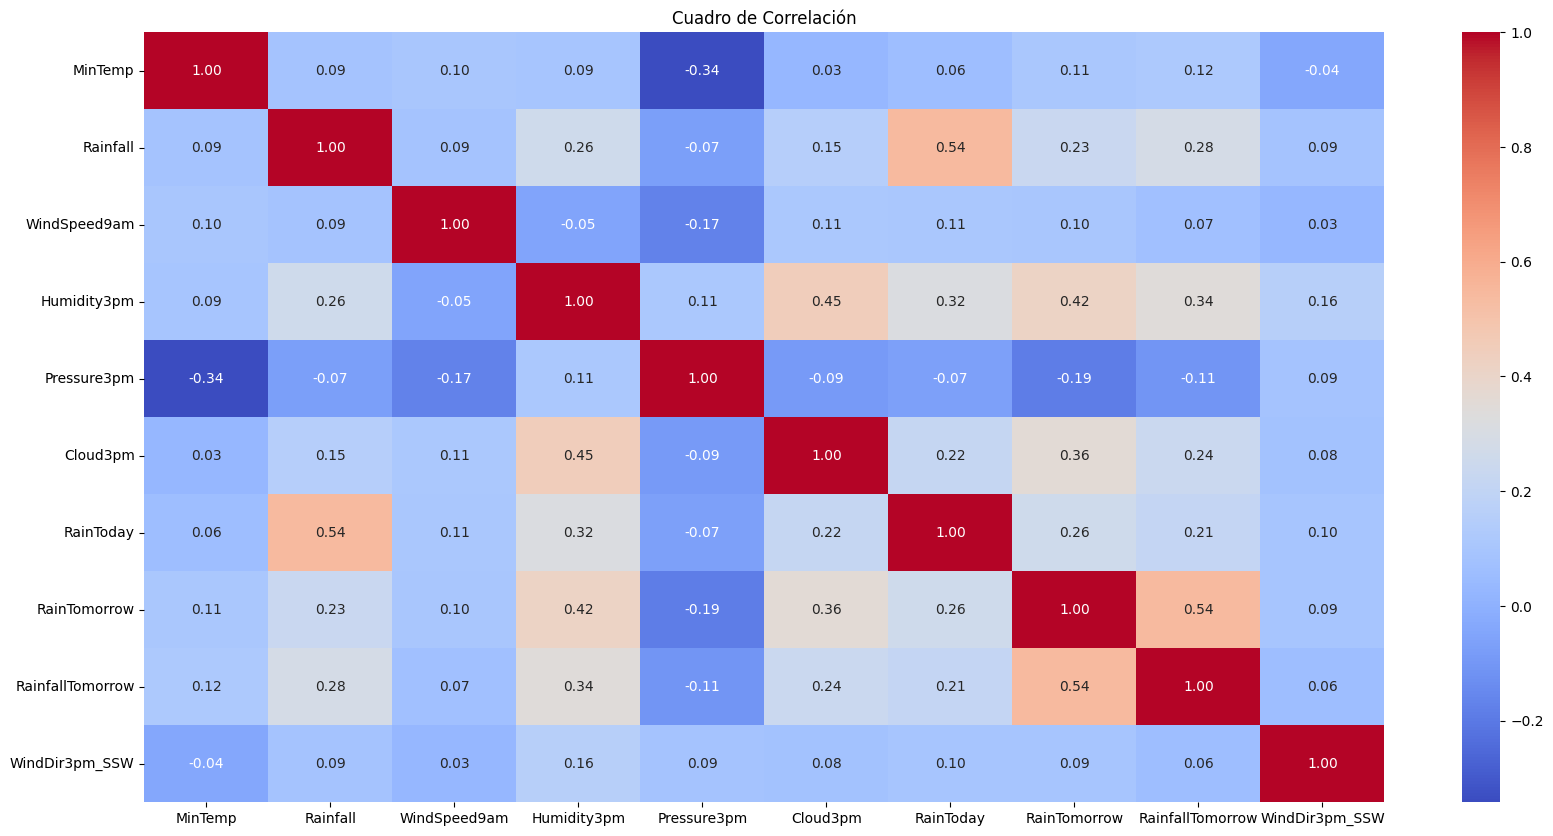

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = df_weather.corr()

# Configura el tamaño de la figura con espacio adicional para las etiquetas de los ejes
plt.figure(figsize=(20, 10))

# Crea un mapa de calor con seaborn para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añade un título al cuadro de correlación
plt.title("Cuadro de Correlación")

# Muestra el cuadro de correlación
plt.show()

## Regresion lineal multiple:

Implementar la solución del problema de regresión con regresión lineal múltiple:

● Probar con el método LinearRegression.

● Probar con métodos de gradiente descendiente.

● Probar con métodos de regularización (Lasso, Ridge, Elasticnet).

● Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE,
MAPE).

El objetivo es predecir la variable 'RainfallTomorrow' a partir de algunas otras:

### Seleccion de caracteristicas para la prediccion:

Se utilizaran todas las caracteristicas que quedaron en el dataset luego de la limpieza del mismo para la regresion.

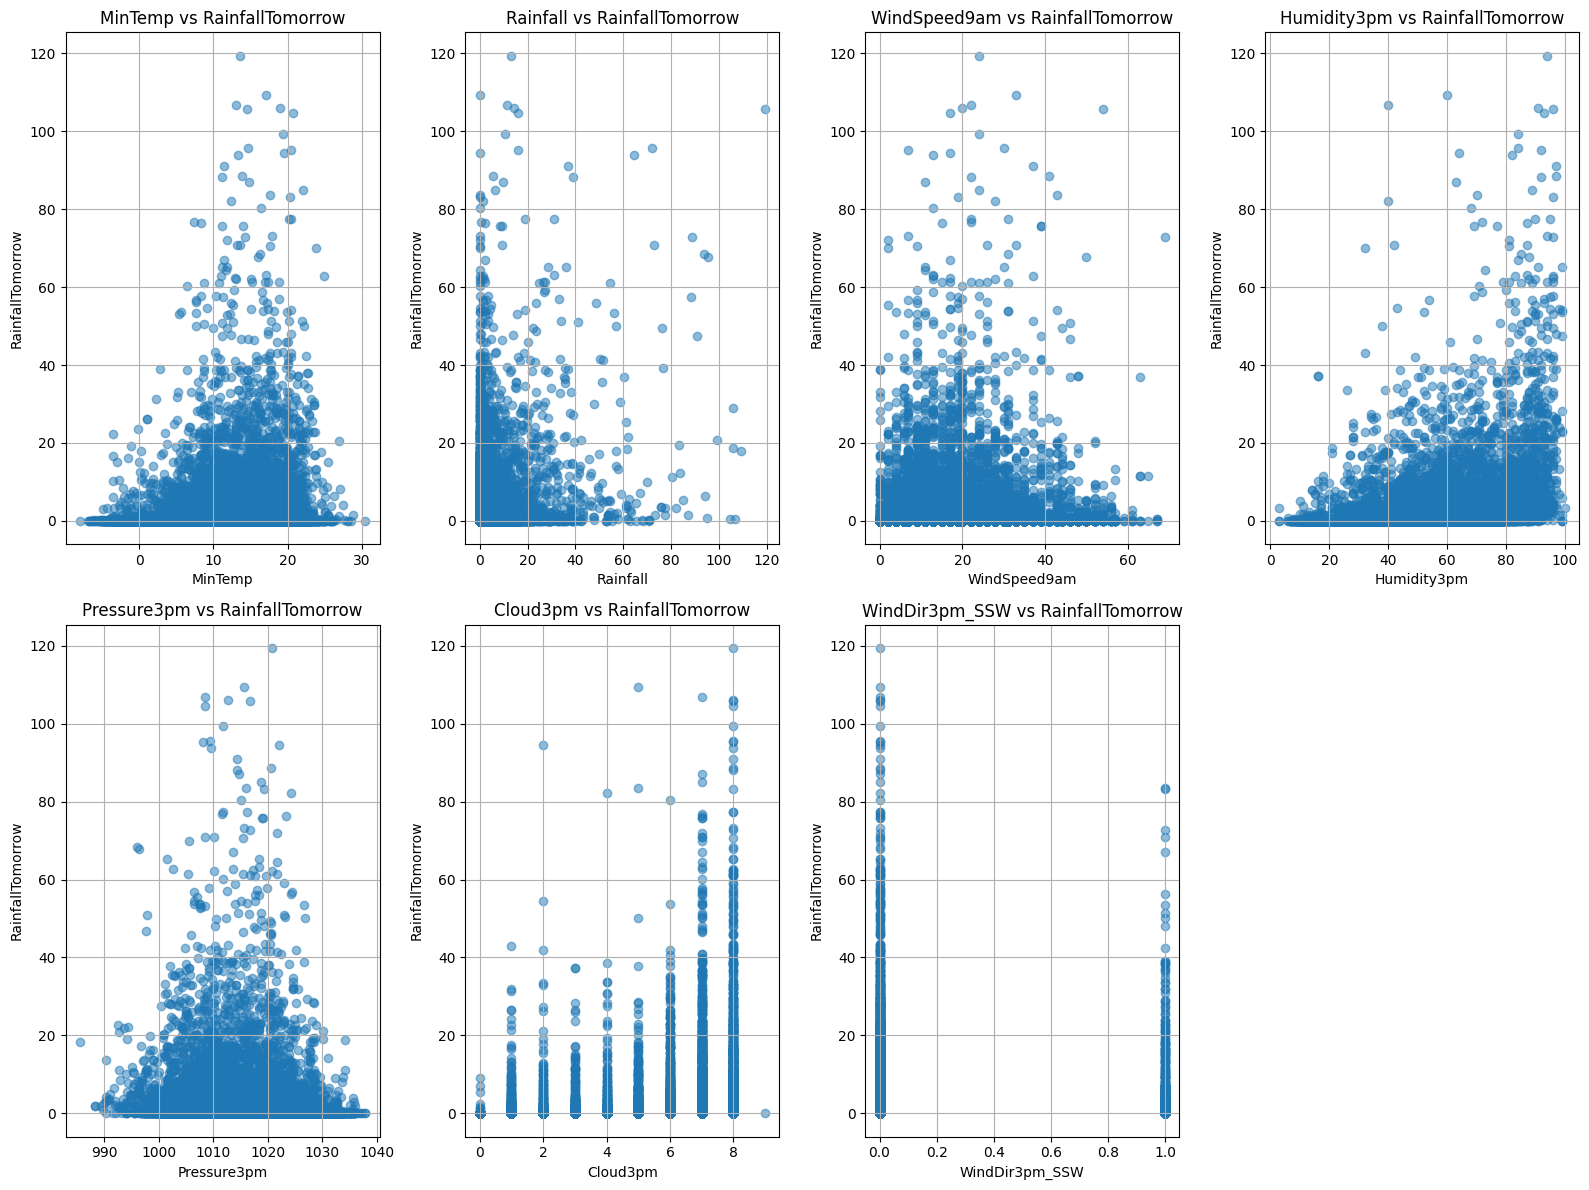

In [ ]:
# Crear una figura con 2 filas y 4 columnas de subplots
plt.figure(figsize=(16, 12))

# Lista de variables con las que comparar "RainfallTomorrow"
variables = ['MinTemp', 'Rainfall', 'WindSpeed9am', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']

# Iterar a través de las variables y crear los subplots
for i, variable in enumerate(variables):
    plt.subplot(2, 4, i+1)
    plt.scatter(df_weather[variable], df_weather['RainfallTomorrow'], alpha=0.5)
    plt.title(f"{variable} vs RainfallTomorrow")
    plt.xlabel(variable)
    plt.ylabel("RainfallTomorrow")
    plt.grid(True)

# Ajustar el espacio entre subplots para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los subplots
plt.show()


### Estandarización de las variables continuas según Z-score

In [ ]:
# Seleccion de las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'Rainfall', 'WindSpeed9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm','RainfallTomorrow']

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Aplica la estandarización a las columnas seleccionadas
df_weather_z = scaler.fit_transform(df_weather[columns_to_standardize])

# Crear un nuevo DataFrame con los datos estandarizados y las mismas columnas
df_weather_z = pd.DataFrame(data=df_weather_z, columns=columns_to_standardize)

# Agrega la columna 'WindDir3pm_SSW' del df original al estandarizado
df_weather_z['WindDir3pm_SSW'] = df_weather['WindDir3pm_SSW']

### Division en conjunto de test y de prueba

In [ ]:
# Seleccionamos las características que deseamos utilizar como variables explicativas
features = df_weather_z[['MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']]

# Selecciona la variable objetivo
target = df_weather_z['RainfallTomorrow']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

Asi quedan divididos los conjuntos de test y prueba:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12128, 7), (3032, 7), (12128,), (3032,))

### Modelo

In [ ]:
# Creacion del modelo de regresion lineal
regresion_lineal = LinearRegression(fit_intercept=True)

# Entrenamiento con los datos de prueba
regresion_lineal.fit(X_train, y_train)

# Predicciones
y_pred = regresion_lineal.predict(X_test)

### Coeficientes:

Coeficientes beta:

In [ ]:
 caracteristicas = np.round(regresion_lineal.coef_, 5)
 caracteristicas

array([ 0.05041,  0.19758,  0.03042,  0.26047, -0.09696,  0.07992,
        0.0174 ])

Ordenada al origen:

In [ ]:
intercept = np.round(regresion_lineal.intercept_, 5)
intercept

0.00312

Se puede ver que la 'Humidity3pm' es la variable que mas peso tiene dentro de la regresion, seguido por 'Rainfall'.

### Metricas

Veremos las métricas a partir de los datos del modelo

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_ols = np.sqrt(mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse_ols:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 0.72
RMSE: 0.85
MAE: 0.42
MAPE: 165.11%


R2:

In [ ]:
r2_entrenamiento = round(regresion_lineal.score(X_train,y_train), 2)
r2_prueba = round(regresion_lineal.score(X_test,y_test), 2)

print(f'R2 entrenamiento: {r2_entrenamiento}')
print(f'R2 prueba: {r2_prueba}')

R2 entrenamiento: 0.18
R2 prueba: 0.19


El R2 para el conjunto de entrenamiento es de 0.18, mientras que para el conjunto de prueba de es de 0.19.

Si bien son valores bajos que indican que nuestro modelo no esta explicando muy bien los datos al ser valores parecidos nos da un indicio de que al menos no hay overfitting.

In [ ]:
caracteristicas_nombres = ['Intercept', 'MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW', 'r2_entrenamiento', 'r2_prueba']
coeficientes = np.insert(caracteristicas, 0, intercept)
coeficientes = np.insert(coeficientes, len(coeficientes), [r2_entrenamiento, r2_prueba])
coeficientes_prediccion = pd.DataFrame(coeficientes, index=caracteristicas_nombres, columns=['Regresion_lineal'])
coeficientes_prediccion

,Regresion_lineal
Intercept,0.00312
MinTemp,0.05041
Rainfall,0.19758
WindSpeed9am,0.03042
Humidity3pm,0.26047
Pressure3pm,-0.09696
Cloud3pm,0.07992
WindDir3pm_SSW,0.01740
r2_entrenamiento,0.18000
r2_prueba,0.19000


### Grafico valores reales vs predicciones:

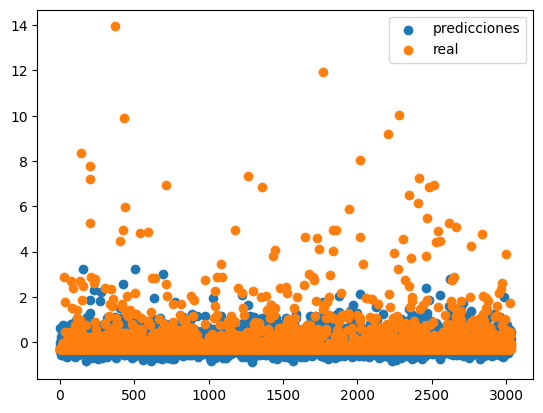

In [ ]:
x = range(len(y_test))
plt.scatter(x, y_pred, label='predicciones')
plt.scatter(x, y_test, label='real')
plt.legend()
plt.show()

### Apartado Regresión Polinómica

Obtenemos los resultados que que el modelo predice y lo intentamos graficas con un modelo de regresión polinómica, ante la dificultad de la representación lineal

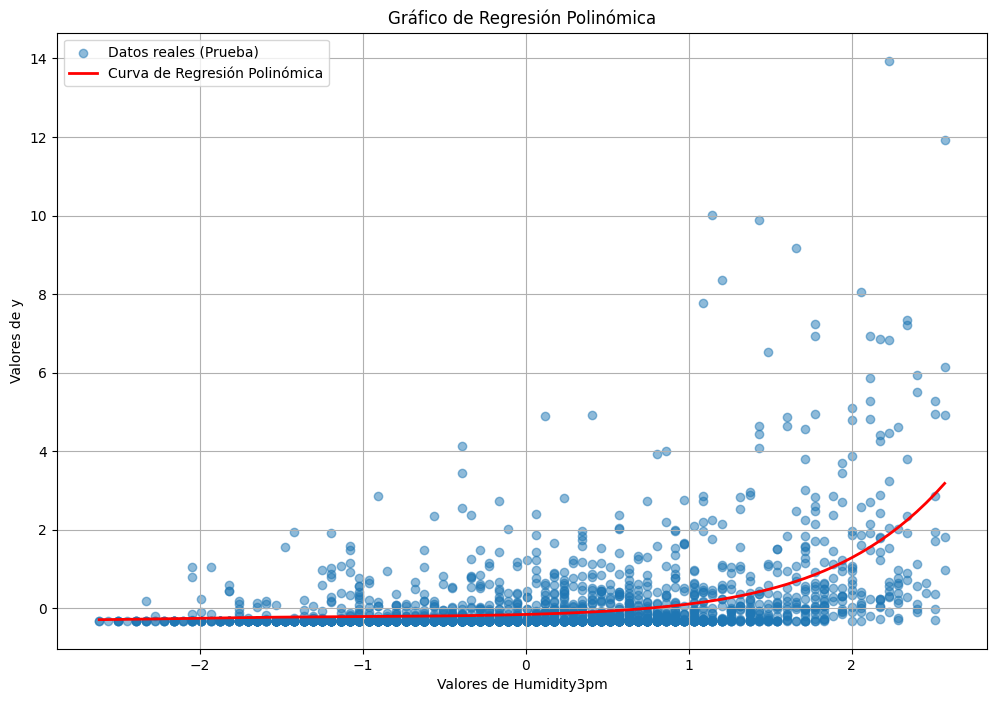

In [ ]:
# Ajusta un modelo de regresión polinómica de grado 6
poly = PolynomialFeatures(degree=6)
X_poly_train = poly.fit_transform(X_train[["Humidity3pm"]])
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Predice los valores de y utilizando el modelo polinómico en datos de prueba
X_poly_test = poly.transform(X_test[["Humidity3pm"]])
y_pred_poly = model.predict(X_poly_test)

# Ordena los datos para graficar la curva de regresión
sorted_indices = X_test["Humidity3pm"].argsort()
x_sorted = X_test["Humidity3pm"].iloc[sorted_indices]
y_pred_sorted = y_pred_poly[sorted_indices]

# Crea una figura grande
plt.figure(figsize=(12, 8))

# Grafica los datos reales de prueba (puntos pequeños)
plt.scatter(X_test["Humidity3pm"], y_test, alpha=0.5, label="Datos reales (Prueba)")

# Grafica la curva de regresión polinómica
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Curva de Regresión Polinómica")

# Etiqueta los ejes y agrega un título
plt.xlabel("Valores de Humidity3pm")
plt.ylabel("Valores de y")
plt.title("Gráfico de Regresión Polinómica")

# Muestra una leyenda
plt.legend()

# Muestra la cuadrícula
plt.grid(True)

# Muestra el gráfico
plt.show()

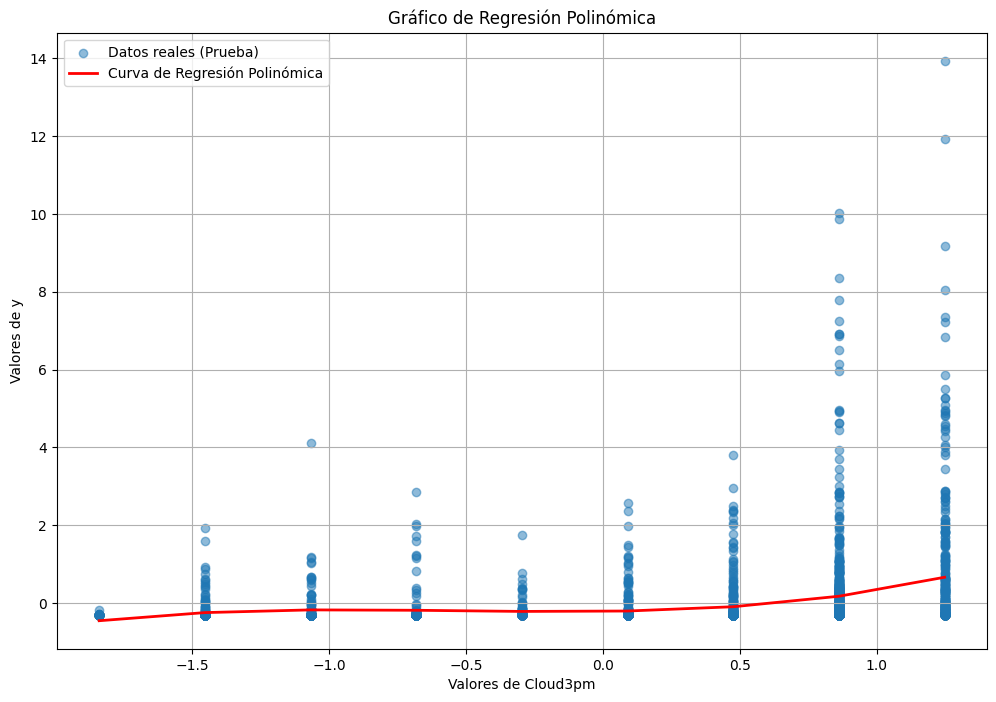

In [ ]:
# Ajusta un modelo de regresión polinómica de grado 3
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train[["Cloud3pm"]])
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Predice los valores de y utilizando el modelo polinómico en datos de prueba
X_poly_test = poly.transform(X_test[["Cloud3pm"]])
y_pred_poly = model.predict(X_poly_test)

# Ordena los datos para graficar la curva de regresión
sorted_indices = X_test["Cloud3pm"].argsort()
x_sorted = X_test["Cloud3pm"].iloc[sorted_indices]
y_pred_sorted = y_pred_poly[sorted_indices]

# Crea una figura grande
plt.figure(figsize=(12, 8))

# Grafica los datos reales de prueba (puntos pequeños)
plt.scatter(X_test["Cloud3pm"], y_test, alpha=0.5, label="Datos reales (Prueba)")

# Grafica la curva de regresión polinómica
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Curva de Regresión Polinómica")

# Etiqueta los ejes y agrega un título
plt.xlabel("Valores de Cloud3pm")
plt.ylabel("Valores de y")
plt.title("Gráfico de Regresión Polinómica")

# Muestra una leyenda
plt.legend()

# Muestra la cuadrícula
plt.grid(True)

# Muestra el gráfico
plt.show()

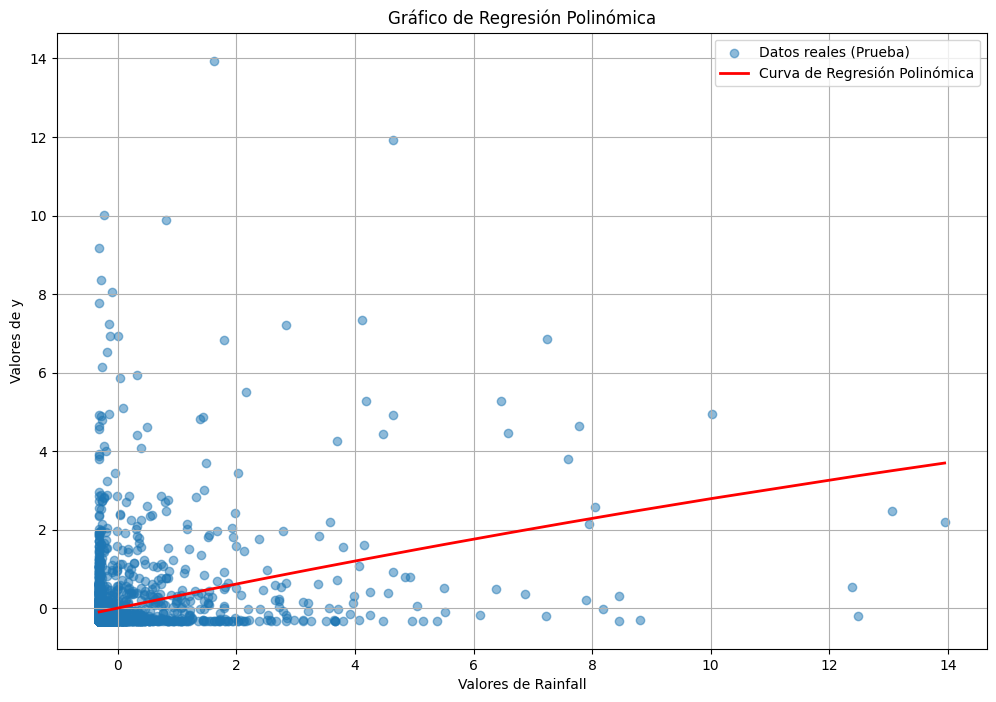

In [ ]:
# Ajusta un modelo de regresión polinómica de grado 2
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train[["Rainfall"]])
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Predice los valores de y utilizando el modelo polinómico en datos de prueba
X_poly_test = poly.transform(X_test[["Rainfall"]])
y_pred_poly = model.predict(X_poly_test)

# Ordena los datos para graficar la curva de regresión
sorted_indices = X_test["Rainfall"].argsort()
x_sorted = X_test["Rainfall"].iloc[sorted_indices]
y_pred_sorted = y_pred_poly[sorted_indices]

# Crea una figura grande
plt.figure(figsize=(12, 8))

# Grafica los datos reales de prueba (puntos pequeños)
plt.scatter(X_test["Rainfall"], y_test, alpha=0.5, label="Datos reales (Prueba)")

# Grafica la curva de regresión polinómica
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label="Curva de Regresión Polinómica")

# Etiqueta los ejes y agrega un título
plt.xlabel("Valores de Rainfall")
plt.ylabel("Valores de y")
plt.title("Gráfico de Regresión Polinómica")

# Muestra una leyenda
plt.legend()

# Muestra la cuadrícula
plt.grid(True)

# Muestra el gráfico
plt.show()

In [ ]:
# Lista de variables para ajustar
variables = ["Humidity3pm", "Cloud3pm", "Rainfall"]

# Grados de polinomio para cada variable (pueden variar según tu análisis)
grados = [6, 4, 3]

# Inicializa listas para almacenar métricas
mse_list = []
r2_list = []

# Itera a través de las variables y los grados
for variable, grado in zip(variables, grados):
    X = X_test[[variable]]
    y = y_test

    # Ajusta un modelo de regresión polinómica
    poly = PolynomialFeatures(degree=grado)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predice los valores de y en los datos de prueba
    y_pred = model.predict(X_poly)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Almacena las métricas
    mse_list.append(mse)
    r2_list.append(r2)

    # Imprime las métricas para cada variable
    print(f"Variable: {variable}, Grado del Polinomio: {grado}")
    print(f"MSE: {mse:.2f}")
    print(f"R^2: {r2:.2f}")
    print("")

# Imprime las métricas generales
print("Métricas Generales:")
print(f"MSE Promedio: {np.mean(mse_list):.2f}")
print(f"R^2 Promedio: {np.mean(r2_list):.2f}")

Variable: Humidity3pm, Grado del Polinomio: 6
MSE: 0.66
R^2: 0.26

Variable: Cloud3pm, Grado del Polinomio: 4
MSE: 0.80
R^2: 0.10

Variable: Rainfall, Grado del Polinomio: 3
MSE: 0.81
R^2: 0.09

Métricas Generales:
MSE Promedio: 0.76
R^2 Promedio: 0.15


In [ ]:
# Lista de variables para ajustar
variables = ["Humidity3pm", "Cloud3pm", "Rainfall"]

# Grados de polinomio para cada variable (pueden variar según tu análisis)
grados = [6, 4, 4]

# Inicializa listas para almacenar métricas
mse_list = []
r2_list = []
mae_list = []

# Ajustar modelos polinómicos para cada variable y calcular las métricas
for variable, grado in zip(variables, grados):
    X_train_var = X_train[[variable]]
    X_test_var = X_test[[variable]]
    y_train_var = y_train

    # Aplicar transformación polinómica a la variable
    poly = PolynomialFeatures(degree=grado)
    X_poly_train_var = poly.fit_transform(X_train_var)
    X_poly_test_var = poly.transform(X_test_var)

    # Ajustar un modelo de regresión lineal con la variable polinómica
    model = LinearRegression()
    model.fit(X_poly_train_var, y_train_var)

    # Predice los valores de y en los datos de prueba
    y_pred_var = model.predict(X_poly_test_var)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred_var)
    r2 = r2_score(y_test, y_pred_var)
    mae = mean_absolute_error(y_test, y_pred_var)

    # Almacena las métricas
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

    # Imprime las métricas para cada variable
    print(f"Variable: {variable}, Grado del Polinomio: {grado}")
    print(f"MSE: {mse:.2f}")
    print(f"R^2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print("")

# Imprime las métricas generales
print("Métricas Generales:")
print(f"MSE Promedio: {np.mean(mse_list):.2f}")
print(f"R^2 Promedio: {np.mean(r2_list):.2f}")
print(f"MAE Promedio: {np.mean(mae_list):.2f}")

Variable: Humidity3pm, Grado del Polinomio: 6
MSE: 0.66
R^2: 0.26
MAE: 0.36

Variable: Cloud3pm, Grado del Polinomio: 4
MSE: 0.81
R^2: 0.10
MAE: 0.41

Variable: Rainfall, Grado del Polinomio: 4
MSE: 0.82
R^2: 0.08
MAE: 0.42

Métricas Generales:
MSE Promedio: 0.76
R^2 Promedio: 0.14
MAE Promedio: 0.40


### Análisis de Residuos

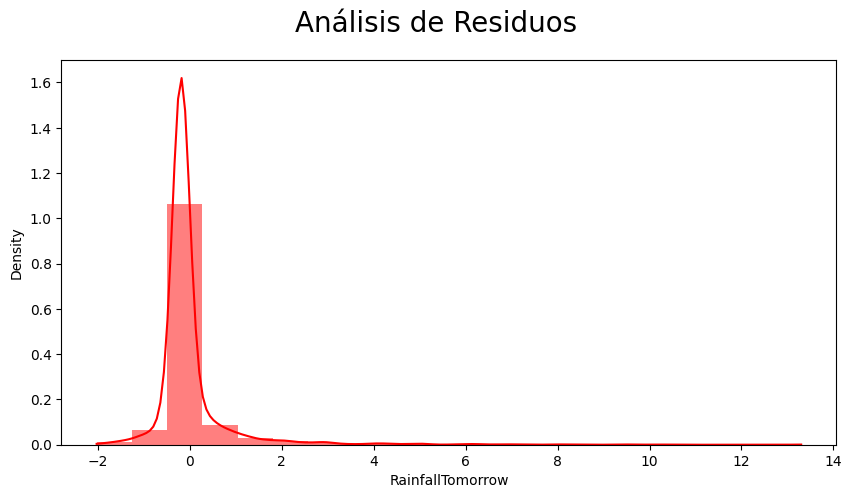

In [ ]:
fig = plt.figure(figsize=(10,5))

sns.histplot((y_test - y_pred), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)
plt.show()

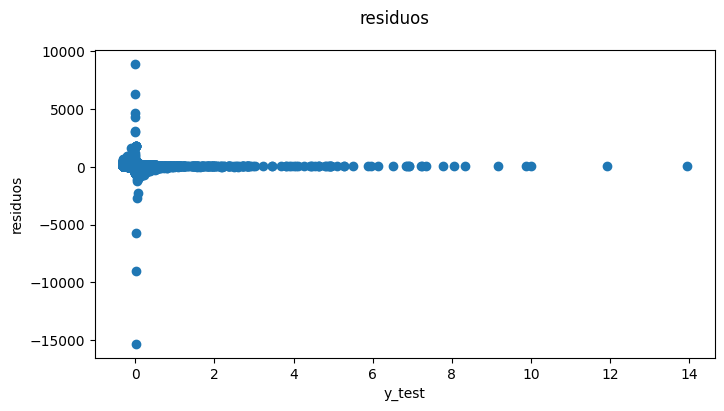

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test,100*(y_test-y_pred)/y_test)
plt.show()

Vemos que los residuos se concentran en el valor x = 0, seguramente debido a que es el valor más frecuente en la variable target

## Gradientes:

### Gradiente Descendente

Funcion de optimizacion:


In [ ]:
def r2(betas, x, y):

    ''' Funcion para calcular el R2 a partir de los coeficientes betas, x e y'''

    n = x.shape[0]

    x = np.hstack((np.ones((n, 1)), x))

    predicciones = np.matmul(x, betas).ravel()
    errores = y - predicciones

    # Calcular la suma de cuadrados totales
    tss = np.sum((y - np.mean(y))**2)

    # Calcular la suma de cuadrados de residuos
    rss = np.sum(errores**2)

    # Calcular el coeficiente de determinación R²
    r2 = 1 - (rss / tss)

    return r2


In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    # Inicializar pesos a cero
    W = np.zeros((m + 1, 1))

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W).ravel()
        error_train = y_train - prediction_train

        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W).ravel()
        error_test = y_test - prediction_test

        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train[:, np.newaxis] * X_train, axis=0)
        gradient = -2/n * grad_sum

        W = W - lr * gradient.reshape(-1, 1)

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return np.round(W, 5)


In [ ]:
# coeficientes_gradiente = coeficientes_prediccion.copy()

In [ ]:
# coeficientes_gradiente_01 = gradient_descent(X_train, y_train, X_test, y_test, epochs=100, lr=0.1)
# coeficientes_gradiente_01

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_01, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_01, X_test, y_test)
# datos_gradiente_01 = np.insert(coeficientes_gradiente_01, len(coeficientes_gradiente_01), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=100, lr=0.1)'] = datos_gradiente_01
# coeficientes_gradiente

Con 100 epocas y un ratio de aprendizaje de 0.1 se puede ver como los coeficientes se acercaron casi a los de nuestra regresion lineal, observando el grafico se nota como a partir de la 10ma epoca ya el error empieza a disminuir muy poco.

¿Que pasaria si lo dejamos en 10 epocas?

In [ ]:
# coeficientes_gradiente_02 = gradient_descent(X_train, y_train, X_test, y_test, epochs=10, lr=0.1)
# coeficientes_gradiente_02

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_02, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_02, X_test, y_test)
# datos_gradiente_02 = np.insert(coeficientes_gradiente_02, len(coeficientes_gradiente_02), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=10, lr=0.1)'] = datos_gradiente_02
# coeficientes_gradiente

Empeoro pero muy poco, resultados muy similares.

¿Si aumentamos las epocas podremos acercanos a los valores exactos?

In [ ]:
# coeficientes_gradiente_03 = gradient_descent(X_train, y_train, X_test, y_test, epochs=250, lr=0.1)
# coeficientes_gradiente_03

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_03, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_03, X_test, y_test)
# datos_gradiente_03 = np.insert(coeficientes_gradiente_03, len(coeficientes_gradiente_03), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=250, lr=0.1)'] = datos_gradiente_03
# coeficientes_gradiente

Resultados muy similares.

Mas epocas?

In [ ]:
# coeficientes_gradiente_04 = gradient_descent(X_train, y_train, X_test, y_test, epochs=400, lr=0.1)
# coeficientes_gradiente_04

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_04, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_04, X_test, y_test)
# datos_gradiente_04 = np.insert(coeficientes_gradiente_04, len(coeficientes_gradiente_04), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=400, lr=0.1)'] = datos_gradiente_04
# coeficientes_gradiente

Variando las epocas con un ratio de aprendizaje fijo de 0.1 en 400 epocas podemos llegar a los mismos valores de coeficientes que con la regresion lineal evitando el costo computacional que requieren los calculos matriciales. De todos modos los anteriores resultados era practicamente identicos.

¿Y si variamos el lr?

In [ ]:
# coeficientes_gradiente_05 = gradient_descent(X_train, y_train, X_test, y_test, epochs=100, lr=0.5)
# coeficientes_gradiente_05

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_05, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_05, X_test, y_test)
# datos_gradiente_05 = np.insert(coeficientes_gradiente_05, len(coeficientes_gradiente_05), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=100, lr=0.5)'] = datos_gradiente_05
# coeficientes_gradiente

Se logro el mismo resultado de la RL en mucho menos tiempo.

Con un lr aun mas grande?

In [ ]:
# coeficientes_gradiente_06 = gradient_descent(X_train, y_train, X_test, y_test, epochs=10, lr=0.8)
# coeficientes_gradiente_06

In [ ]:
# r2_entrenamiento = r2(coeficientes_gradiente_06, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gradiente_06, X_test, y_test)
# datos_gradiente_06 = np.insert(coeficientes_gradiente_06, len(coeficientes_gradiente_06), [r2_entrenamiento, r2_prueba])
# coeficientes_gradiente['GD(epochs=10, lr=0.8)'] = datos_gradiente_06
# coeficientes_gradiente

Al parecer con un ratio de aprendizaje tan grande el algoritmo empieza a alejarse de minimo, es decir diverge.

Conclusion:

- De todas las configuraciones de hiperparametros probadas al parecer la mejor es la de 100 epocas con un lr de 0.5, se logro llegar al minimo en bastante menos tiempo que las anteriores.

- Por otro lado en todas las ejecuciones con distintos hiperparametros los errores de train y test fueron muy parecidos lo que nos hace descartar la idea de overfitting.

- El descenso de gradiente puede ser una solucion para nuestro conjunto de datos si queremos ahorrar costo computacional para los calculos, es una opcion posible. De todos modos para lo que es nuestro dataset y teniendo en cuenta los recursos disponibles por una cuestion de evitar setear hiperparametros se prefiere la regresion lineal multiple.

### Gradiente Descendente Estocastico:

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.5, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    y_train = y_train.values

    for i in range(epochs):

        print(f'Epoca: {i+1}')

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)

        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]

            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            prediction_test = np.squeeze(prediction_test)

            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return np.round(W, 5)

In [ ]:
# coeficientes_gde = pd.DataFrame(coeficientes, index=caracteristicas_nombres, columns=['Regresion_lineal'])

In [ ]:
# coeficientes_gds_01 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.1, epochs=100)

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_01, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_01, X_test, y_test)
# datos_gradiente_01 = np.insert(coeficientes_gds_01, len(coeficientes_gds_01), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=100, lr=0.1)'] = datos_gradiente_01
# coeficientes_gde

Evidentemente tenemos un lr muy alto y demasiadas epocas. Los coeficientes estan lejisimo de su valor optimo.

Probamos bajar ambos.

In [ ]:
# coeficientes_gds_02 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.001, epochs=5)

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_02, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_02, X_test, y_test)
# datos_gradiente_02 = np.insert(coeficientes_gds_02, len(coeficientes_gds_02), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=5, lr=0.01)'] = datos_gradiente_02
# coeficientes_gde

El resultado comparandolo con la regresion lineal es bastante aceptable, aunque explica aun menos.

Si bajamos aun mas el lr y las epocas?

In [ ]:
# coeficientes_gds_03 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.00001, epochs=3)

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_03, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_03, X_test, y_test)
# datos_gradiente_03 = np.insert(coeficientes_gds_03, len(coeficientes_gds_03), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=3, lr=0.00001)'] = datos_gradiente_03
# coeficientes_gde

Nos alejamos mucho y el modelo no explica nada.

Tal vez bajamos mucho el lr y no llega a converger con las epocas.

Vamos a subir un poco ambos hiperparametros.

In [ ]:
# coeficientes_gds_04 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.0001, epochs=5)

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_04, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_04, X_test, y_test)
# datos_gradiente_04 = np.insert(coeficientes_gds_04, len(coeficientes_gds_04), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=3, lr=0.00001)'] = datos_gradiente_04
# coeficientes_gde

Tenemos un modelo que explica bastante similar al de la regresion lineal.

Vamos a subir un poco mas ambos hiperparametros.

In [ ]:
# coeficientes_gds_05 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.0001, epochs=10)
# coeficientes_gds_05

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_05, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_05, X_test, y_test)
# datos_gradiente_05 = np.insert(coeficientes_gds_05, len(coeficientes_gds_05), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=10, lr=0.0001)'] = datos_gradiente_05
# coeficientes_gde

Explica un poco menos que el anterior y le tomo algunas epocas mas. Muy cercano tambien a la regresion lineal en cuanto a R2.

In [ ]:
# coeficientes_gds_06 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.0001, epochs=7)
# coeficientes_gds_06

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_06, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_06, X_test, y_test)
# datos_gradiente_06 = np.insert(coeficientes_gds_06, len(coeficientes_gds_06), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=7, lr=0.0001)'] = datos_gradiente_06
# coeficientes_gde

Mejores resultados que el anterior, subimos una epoca mas.

In [ ]:
# coeficientes_gds_07 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.0001, epochs=8)
# coeficientes_gds_07

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_07, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_07, X_test, y_test)
# datos_gradiente_07 = np.insert(coeficientes_gds_07, len(coeficientes_gds_07), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=8, lr=0.0001)'] = datos_gradiente_07
# coeficientes_gde

Mejoramos los resultados  con este lr, aunque la mejor configuracion sigue siendo 3 epocas, con lr de 0.00001.

Probamos un lr muy bajo y con bastantes epocas.

In [ ]:
# coeficientes_gds_08 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=30)
# coeficientes_gds_08

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_08, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_08, X_test, y_test)
# datos_gradiente_08 = np.insert(coeficientes_gds_08, len(coeficientes_gds_08), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=30, lr=0.000001)'] = datos_gradiente_08
# coeficientes_gde

No explica nada, muy lejos de la regresion.

In [ ]:
# coeficientes_gds_09 = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=60)
# coeficientes_gds_09

In [ ]:
# r2_entrenamiento = r2(coeficientes_gds_09, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gds_09, X_test, y_test)
# datos_gradiente_09 = np.insert(coeficientes_gds_09, len(coeficientes_gds_09), [r2_entrenamiento, r2_prueba])
# coeficientes_gde['GDE(epochs=60, lr=0.000001)'] = datos_gradiente_09
# coeficientes_gde

Explica mas que el anterior pero sigue sin explicar nada de los datos y ademas tomo demasiadas epocas.

Conclusiones:

- De todas las pruebas que se hicieron la mejor configuracion de hiperparametros es la de lr de 0.0001 en 3 epocas.

- Con los anteriores hp se logro un modelo que tenga un r2 bastante similar al de la regresion lineal multiple.

- En cuanto a cuestiones de tiempos el proceso en si fue el mas lento por ahora. Dependiendo de la cantidad de epocas que se hayan seteado tarda mucho o un poco menos, pero aun asi con una 1 epoca tarda demasiado. Esto es debido a la gran cantidad de filas de entrenamiento que tenemos.

- Con los recursos que tenemos y para este dataset se prefiere mas el GD con todas las filas por sobre este, pero la regresion lineal multiple entre todos.

### Gradiente Descendente Mini Batch:

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    y_train = y_train.values

    for i in range(epochs):
        print(f'Epoca: {i+1}')
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)

            error_test = y_test.values.ravel() - prediction_test.ravel()

            test_mse = np.mean(error_test ** 2)

            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [ ]:
# coeficientes_gdmb = pd.DataFrame(coeficientes, index=caracteristicas_nombres, columns=['Regresion_lineal'])

In [ ]:
# coeficientes_gdmb_01 = mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=1212)
# coeficientes_gdmb_01

In [ ]:
# r2_entrenamiento = r2(coeficientes_gdmb_01, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gdmb_01, X_test, y_test)
# datos_gdmb_01 = np.insert(coeficientes_gdmb_01, len(coeficientes_gradiente_01), [r2_entrenamiento, r2_prueba])
# coeficientes_gdmb['GDMB(lr=0.01, epochs=100, batch_size=1212)'] = datos_gdmb_01
# coeficientes_gdmb

Algunos coeficientes ya estan cerca del valor de la regresion lineal, y los R2 de entrenamiento y prueba son similares.

Vamos a probar si con el mismo lr y algunas epocas mas se logran los mismos coeficientes.

In [ ]:
# coeficientes_gdmb_02 = mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=300, batch_size=1212)
# coeficientes_gdmb_02

In [ ]:
# r2_entrenamiento = r2(coeficientes_gdmb_02, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gdmb_02, X_test, y_test)
# datos_gdmb_02 = np.insert(coeficientes_gdmb_02, len(coeficientes_gradiente_02), [r2_entrenamiento, r2_prueba])
# coeficientes_gdmb['GDMB(lr=0.01, epochs=300, batch_size=1212)'] = datos_gdmb_02
# coeficientes_gdmb

Aparentemente con ese lr y mas epocas no llega a converger (se probo incluso subiendo bastante) pero el resultado esta casi a punto.

Probamos con un lr mayor a ver que pasa.

In [ ]:
# coeficientes_gdmb_03 = mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.1, epochs=100, batch_size=1212)
# coeficientes_gdmb_03

In [ ]:
# r2_entrenamiento = r2(coeficientes_gdmb_03, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gdmb_03, X_test, y_test)
# datos_gdmb_03 = np.insert(coeficientes_gdmb_03, len(coeficientes_gradiente_03), [r2_entrenamiento, r2_prueba])
# coeficientes_gdmb['GDMB(lr=0.1, epochs=100, batch_size=1212)'] = datos_gdmb_03
# coeficientes_gdmb

En 100 epocas se logra un modelo muy similar al primero con un lr mas grande.

Vamos a subir un poco mas el valor del lr y bajar las epocas.

In [ ]:
# coeficientes_gdmb_04 = mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.3, epochs=50, batch_size=1212)
# coeficientes_gdmb_04

In [ ]:
# r2_entrenamiento = r2(coeficientes_gdmb_04, X_train.values, y_train.values)
# r2_prueba = r2(coeficientes_gdmb_04, X_test, y_test)
# datos_gdmb_04 = np.insert(coeficientes_gdmb_04, len(coeficientes_gradiente_04), [r2_entrenamiento, r2_prueba])
# coeficientes_gdmb['GDMB(lr=0.3, epochs=50, batch_size=1212)'] = datos_gdmb_04
# coeficientes_gdmb

Los resultados estan muy cerca nuevamente, habria que probar si con algunas epocas mas logramos con un lr mas bajo llegar aun mas cerca de los valores optimos en menos de 100 epocas.

Conclusion:

- Todas las configuraciones de hiperparametros proporcionaron resultados muy cercanos a los valores optimos de los parametros.

- Todos los modelos explican mas o menos igual la variabilidad de los datos, por cuestiones de tiempos.

- Se prefiere para nuestros datos por sobre el estocastico pero se sigue prefiriendo la regresion lineal multiple.

## Regularizacion:

### Ridge

In [ ]:
modelo = make_pipeline(
    RidgeCV(
       alphas          = np.logspace(-10, 10, 200),
       fit_intercept   = True,
       store_cv_values = True
    )
)

_ = modelo.fit(X_train, y_train)

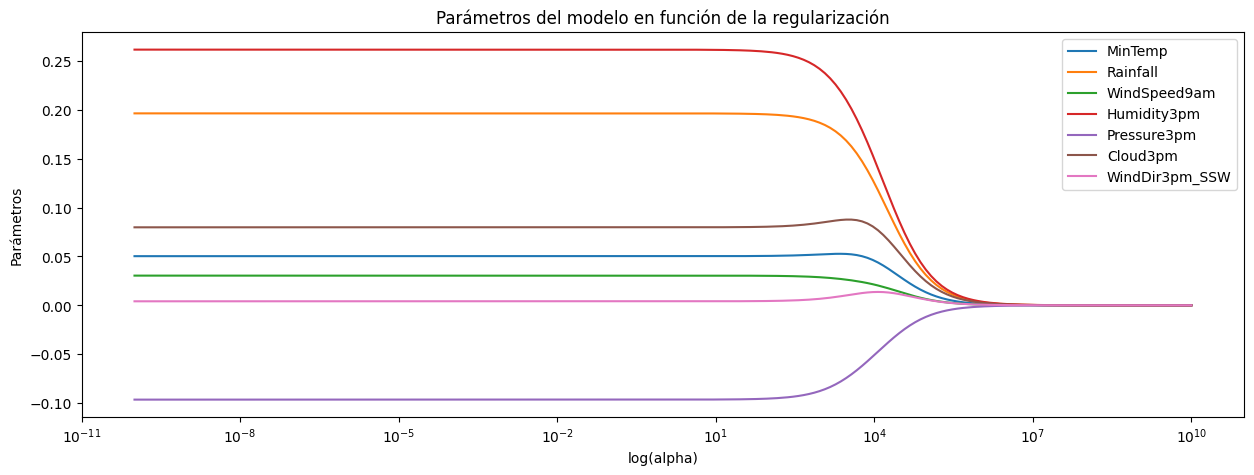

In [ ]:
# Evolución de los parámetros en función de alpha

# Obtengo los alphas
alphas = modelo.steps[0][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

In [ ]:
best_alpha = modelo.named_steps['ridgecv'].alpha_
print("Mejor valor de alpha:", best_alpha)

Mejor valor de alpha: 289.9422853882881


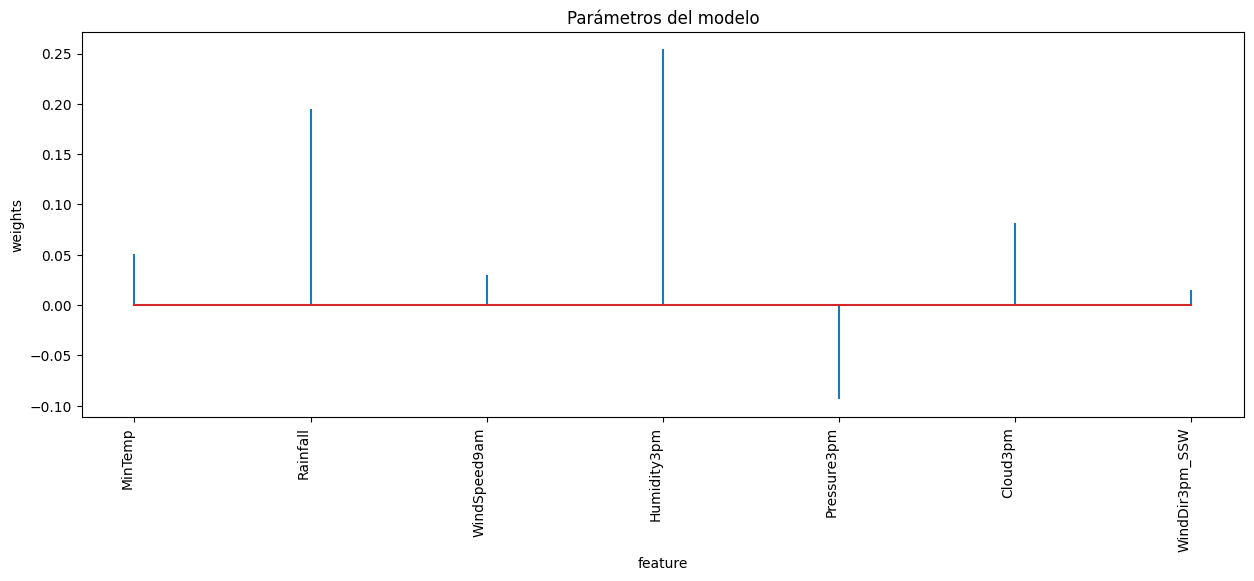

In [ ]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': modelo.steps[0][1].coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo

rmse_ridge = mean_squared_error(y_test,
                y_pred,
                squared = False
             ).round(4)

print(f"El error (rmse) de test es: {rmse_ridge}")

El error (rmse) de test es: 0.8504


In [ ]:
R2 = metrics.r2_score(y_test, y_pred).round(4)
R2

0.1897

Podemos notar que con la regularización Ridge el alpha óptimo para la penalización de nuestro modelo es de aproximadamente 290. El coeficiente más relevante sigue siendo Humidity3pm, mientras que los demás parecen haber perdido significancia. El RMSE bajó respecto del modelo inicial de 0.81 a 0.80, mientras que el R2 apenas descendió, lo que podría indica que la regularización hizo mas tolerante al modelo respecto de valores extraños aunque perdiendo un poco de explicabilidad.

### Lasso

In [ ]:
modelo = make_pipeline(LassoCV(
                           alphas=np.logspace(-10, 10, 200),
                           cv=10
                        )
         )

_ = modelo.fit(X_train, y_train)

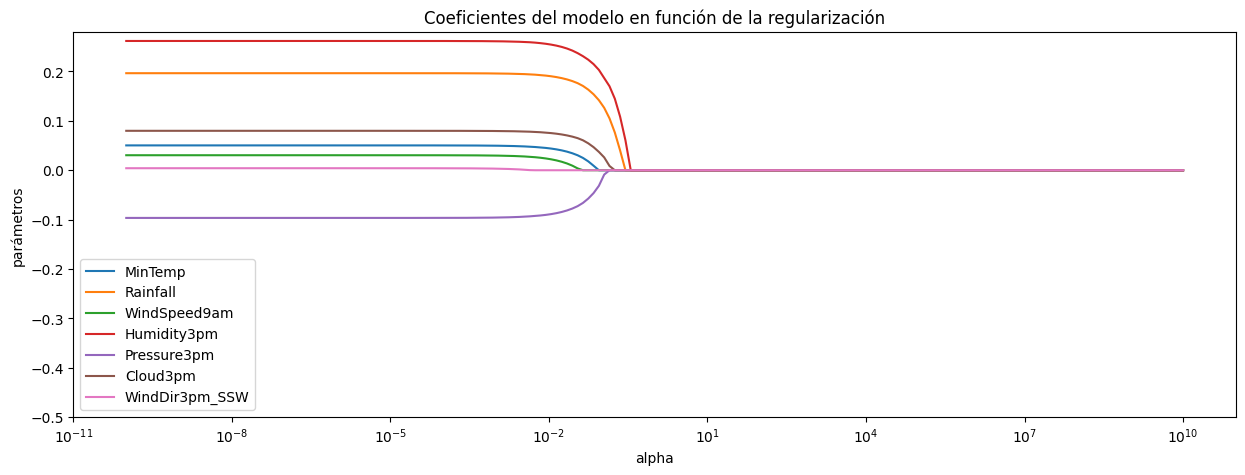

In [ ]:
# Evolución de los parámetros en función de alpha

mod = modelo.steps[0][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {modelo[0].alpha_}")

Mejor valor de alpha encontrado: 0.002171117945694505


In [ ]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,MinTemp,0.049003
1,Rainfall,0.196504
2,WindSpeed9am,0.028941
3,Humidity3pm,0.259512
4,Pressure3pm,-0.095191
5,Cloud3pm,0.079039


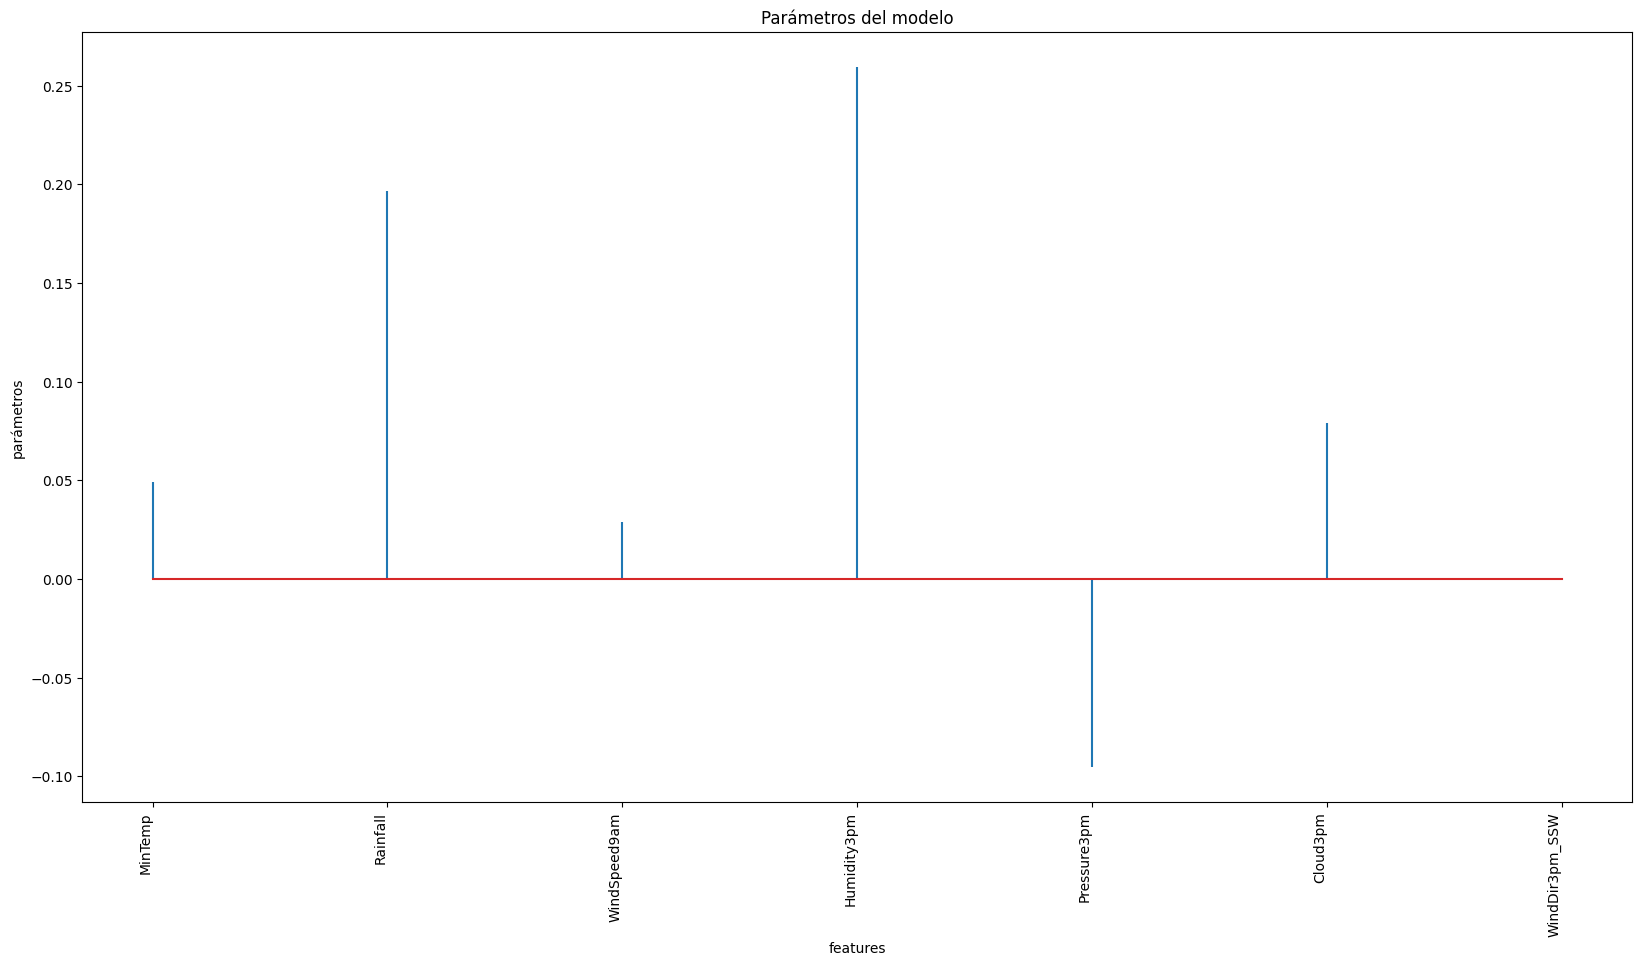

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo

rmse_lasso = mean_squared_error(y_test,y_pred,squared = False).round(4)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 0.8503


In [ ]:
R2 = metrics.r2_score(y_test, y_pred).round(4)
R2

0.1899

Podemos notal que con la regularización Lasso el alpha óptimo para la penalización de nuestro modelo es sumamente cercano a 0, esto indica que la penalización es muy poco usada realmente. El coeficiente más relevante sigue siendo Humidity3pm, mientras que la dirección del viento desapareció como coeficiente explicativo. El RMSE bajó respecto del modelo inicial de 0.81 a 0.80, mientras que el R2 casi se mantiene en 0.18, lo que podría indica que la regularización hizo mas tolerante al modelo respecto de valores extraños, pero de manera infima.

### Elastic Net

In [ ]:
modelo = make_pipeline(ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-10, 10, 200),
                              cv              = 10
                           )
         )

_ = modelo.fit(X_train, y_train)

mod = modelo.steps[0][1]

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4735.021083466105, tolerance: 1.1496664495375524
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4735.017248298011, tolerance: 1.1496664495375524
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/li

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,mod.alphas_,mse_cv,rmse_cv
1326,0.99,2.171118e-03,0.845065,0.919274
523,0.50,4.347013e-03,0.845065,0.919274
1126,0.95,2.171118e-03,0.845066,0.919275
926,0.90,2.171118e-03,0.845067,0.919275
725,0.70,2.736440e-03,0.845068,0.919276
...,...,...,...,...
501,0.50,7.067181e-01,1.027002,1.013411
500,0.50,8.907355e-01,1.027002,1.013411
499,0.50,1.122668e+00,1.027002,1.013411
604,0.70,3.962689e+09,1.027002,1.013411


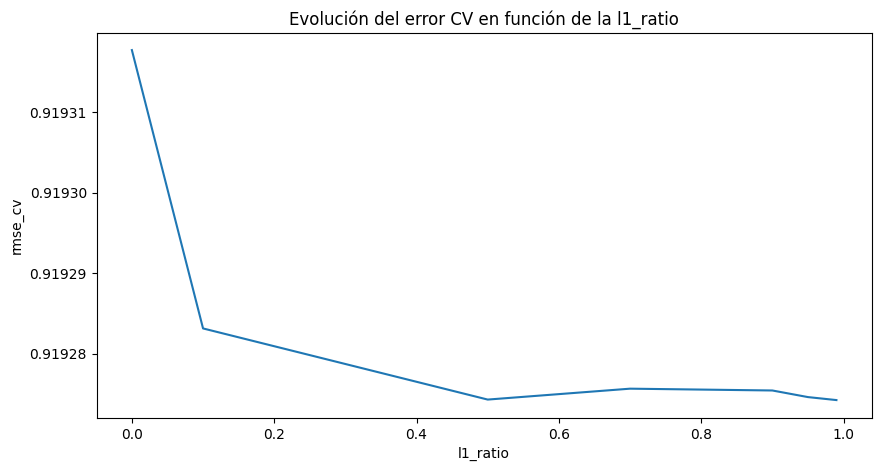

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.002171117945694505
Mejor valor de l1_ratio encontrado: 0.99


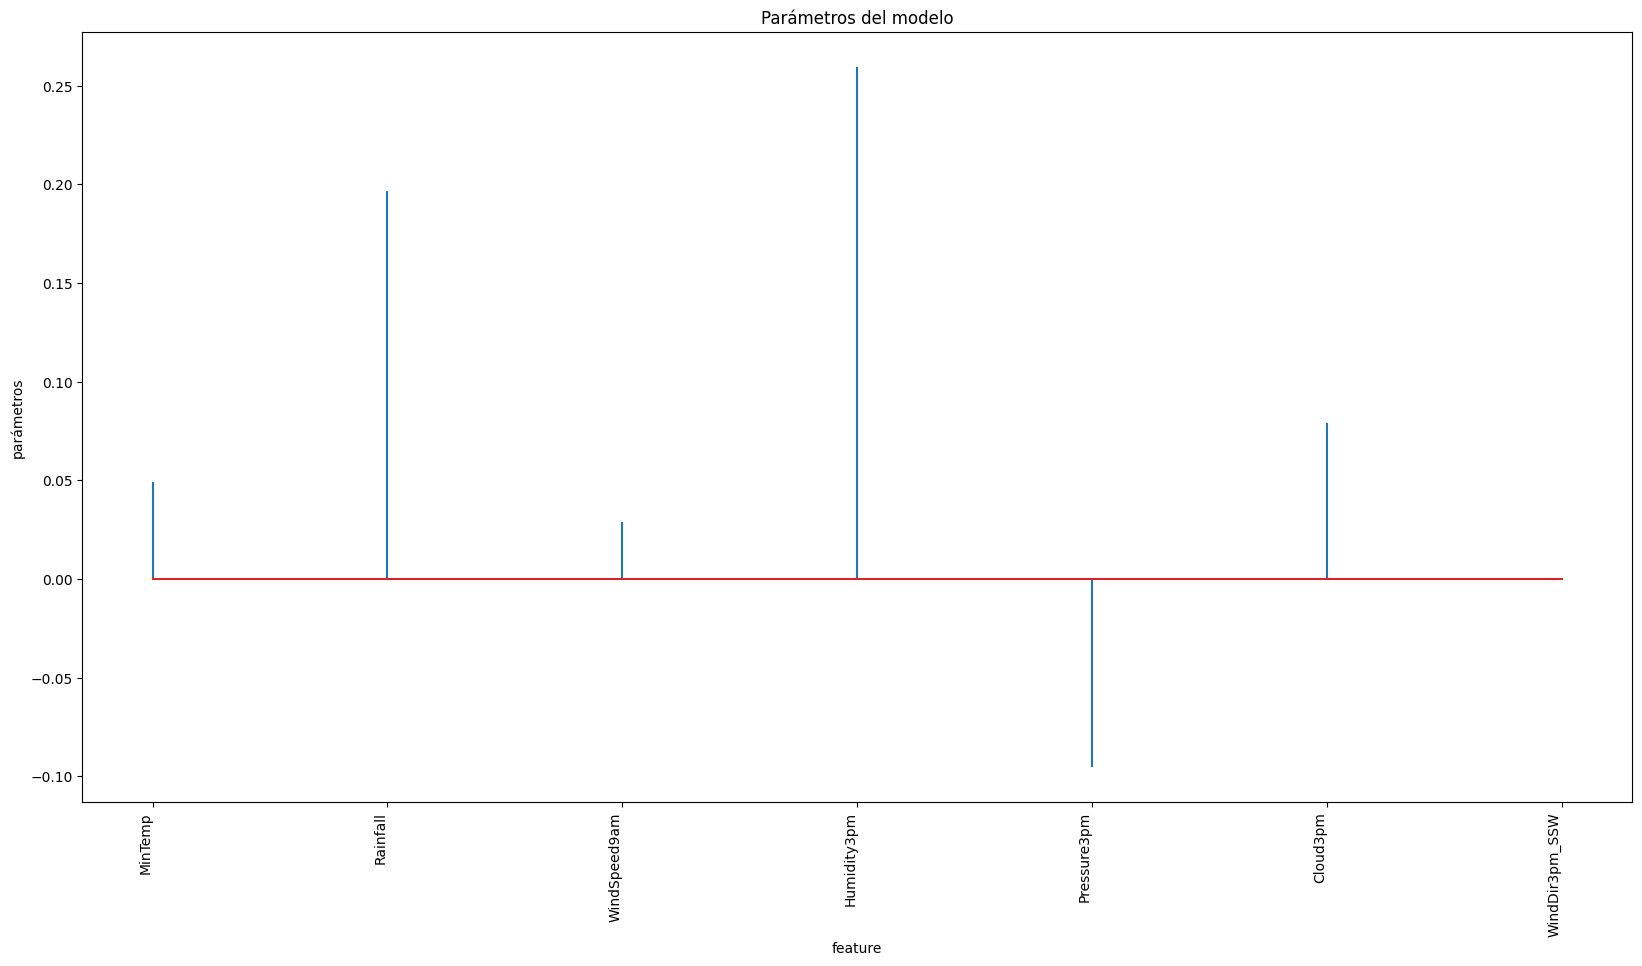

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo

rmse_elastic = mean_squared_error(y_test,y_pred, squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 0.8503322795699277


In [ ]:
R2 = metrics.r2_score(y_test, y_pred).round(4)
R2

0.1899

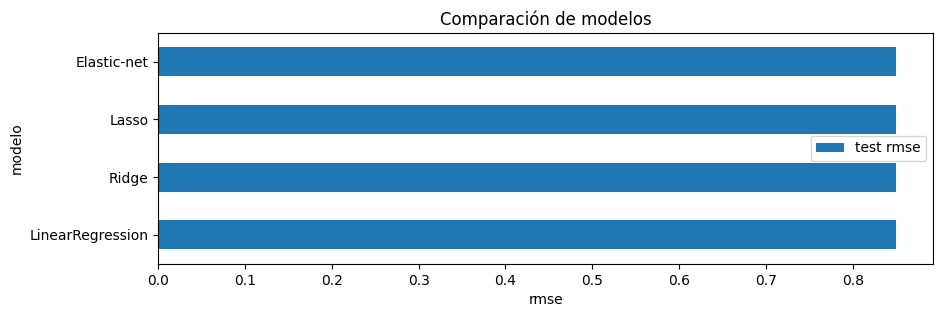

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

No aparecen diferencias significativas respecto a los distintos métodos de regularización implementados, apenas el RMSE descendió 3 milésimas. Esto podría indicar que el modelo no logra aprovechar significativamente los métodos de regularización. Explicaciones posibles pueden tener que ver con la falta de explicabilidad de las variables o con el desbalanceo del dataset, por ejemplo.

# 3. Clasificacion:

In [ ]:
def boxplots(X,y):

  data = pd.concat([pd.DataFrame(y),
                    pd.DataFrame(X, columns=X.columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 + 1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='RainTomorrow', y=feature, data=data, ax=axes[row, col])
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('RainTomorrow')
      axes[row, col].set_ylabel(feature)

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()


Balanceo de clases en el dataset entero:

In [ ]:
# Porcentaje de clases en 'RainTomorrow' en todo el dataset:
( df_weather['RainTomorrow'].value_counts() / df_weather['RainTomorrow'].shape[0] ) * 100

0    75.969657
1    24.030343
Name: RainTomorrow, dtype: float64

Hay mas filas con valores 'No' que 'Si'

## Regresion logistica (sin balancear clases):

En primer lugar probamos una regresion logistica sin balanceo de clases a ver que resultados obtenemos:

Division train-test

In [ ]:
# Variables explicativas:
# No incluimos RainfallTomorrow porque es evidente que los dias que 'RainfallTomorrow' > 0 entonces 'RainToday' == 1.
features = df_weather_z[['MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']]
features['RainToday'] = df_weather['RainToday']

# Variable objetivo:
target = df_weather['RainTomorrow']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

Observamos en las features del conjunto de train

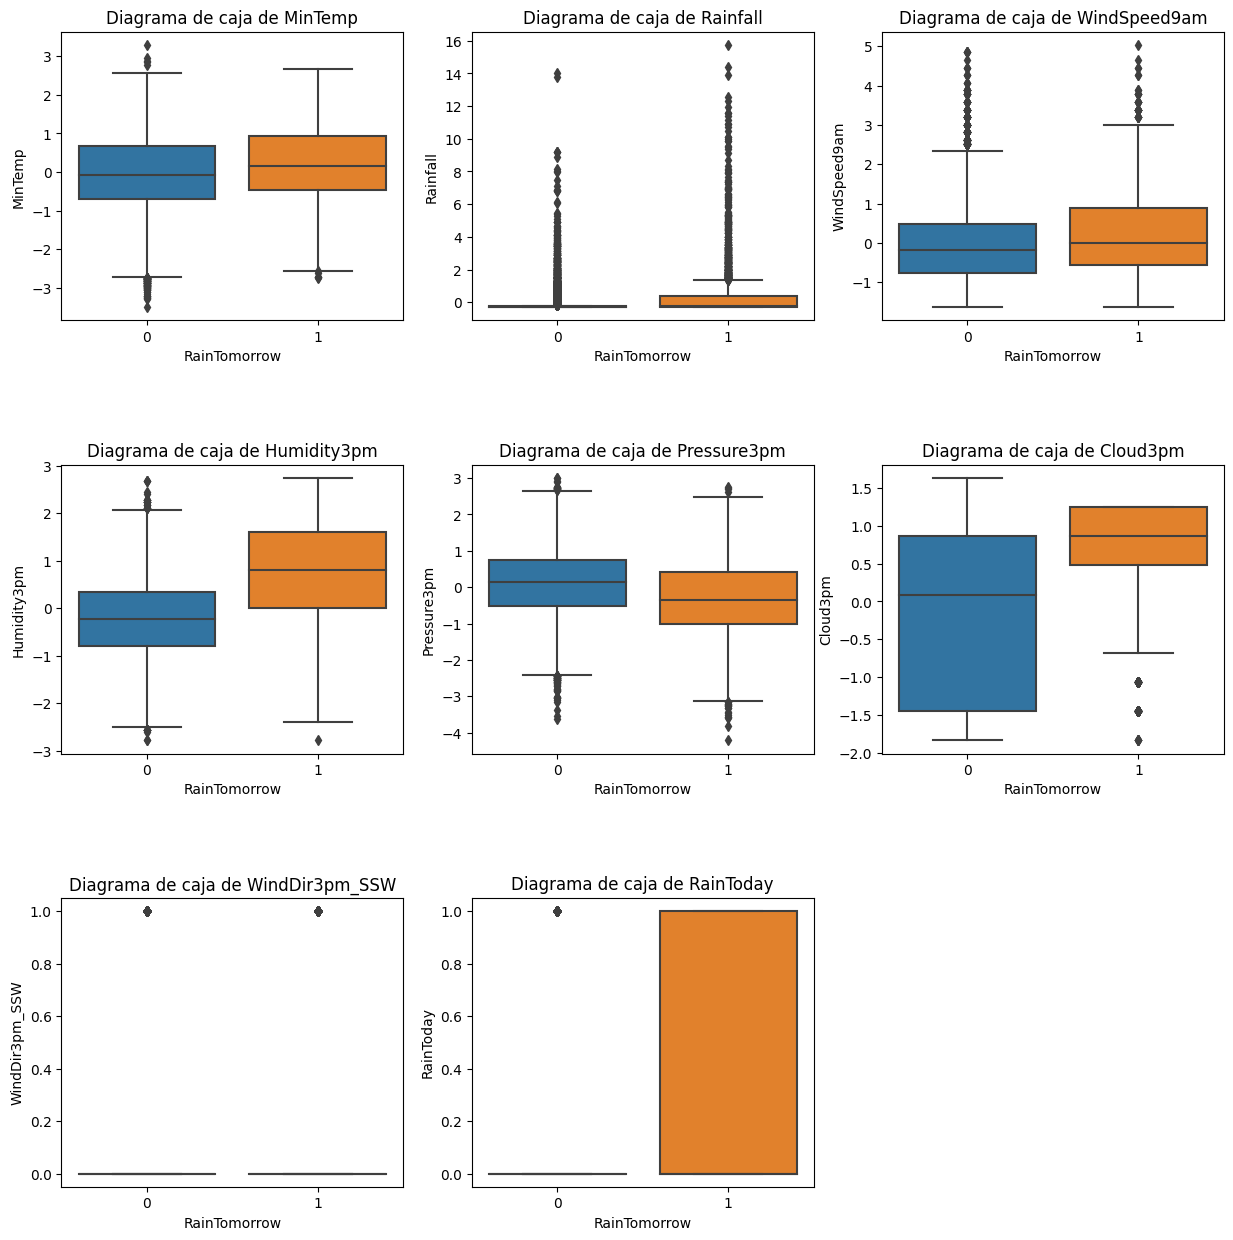

In [ ]:
boxplots(X_train, y_train)

- En 'MinTemp' no es observable un umbral a partir del cual podamos decir cuando llovio mañana (o no llovio) hoy se estuvo por lo gral por encima (o por debajo) de tal temperatura minima.

- En 'Rainfall' se puede ver que por lo general, si no llueve mañana hoy por lo general no llueve (salvo situaciones atipicas) y los dias que si llueve mañana, por lo general hoy cae alguna cantidad de agua. En ambos casos es atipico que llueva mucho pero es evidente que la variable sirve como explicativa.

- 'WindSpeed9am' esta en una situacion similar a 'MinTemp'

- En 'Humidity3pm' se puede ver que desde 0 en adelante se encuentran el 75% de las observaciones cuando si llueve mañana, y que de 0.3 para abajo el 75% de las observaciones cuando no llueve mañana. Parece una buena variable explicativa.

- En 'Pressure3pm' no se detecta un umbral que divida.

- En 'Cloud3pm' cuando si llueve mañana el 75% de las observaciones estan sobre 0.5 mientras que cuando no llueve mañana el 75% estan por debajo de 0.7. Puede servir para explicar.

- En 'WindDir3pm_SSW' la mayoria de veces en haya llovido o no mañana, no hubo viento del SSW, por lo que no parece una buena variable explicativa.

- En 'RainToday' si mañana no llueve hoy por lo gral no llueve salvo algunos atipicos. En cambio si mañana llueve pareceria que es bastante probable que hoy llueva. Puede servir como explicativa.

In [ ]:
# El conjunto de entrenamiento nos quedo desbalanceado en proporciones similares al dataset entero.
( y_train.value_counts() / y_train.shape[0] ) * 100

0    75.939974
1    24.060026
Name: RainTomorrow, dtype: float64

In [ ]:
# Regresion logistica y entrenamiento:
regresion_logistica_desbalanceada = LogisticRegression(random_state=42)
regresion_logistica_desbalanceada.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Predicciones train:
y_pred_train = regresion_logistica_desbalanceada.predict(X_train)

# Predicciones test:
y_pred_test = regresion_logistica_desbalanceada.predict(X_test)

In [ ]:
print("Metricas train: ")
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

Metricas train: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      9210
           1       0.70      0.45      0.55      2918

    accuracy                           0.82     12128
   macro avg       0.77      0.69      0.72     12128
weighted avg       0.81      0.82      0.81     12128

[[8651  559]
 [1603 1315]]


In [ ]:
print("Metricas test: ")
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

Metricas test: 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2307
           1       0.72      0.46      0.56       725

    accuracy                           0.83      3032
   macro avg       0.78      0.70      0.73      3032
weighted avg       0.82      0.83      0.81      3032

[[2174  133]
 [ 388  337]]


In [ ]:
#           Predicciones
#             0      1
#         0 [[TN    FP]
# Reales  1 [ FN    TP]]

* A simple vista no parece haber overfitting ya que las metricas de test y train dan resultados similares.

En metricas de test:

* No nos sirve el accuracy porque el dataset esta desbalanceado.

Como el dataset esta desbalanceado y los FN y FP son ambos igual de importantes, nos interesa que le pegue a ambas situaciones, es decir que si predice lluvia llueva y que si dice que no, que no llueva, vamos a utilizar el F1-score.

* Clase 0: 0.89
* Clase 1: 0.56

Vemos que para la clase 0 el modelo clasifica bastante bien, pero para la clase 1 es bastante malo.

Lo anterior era algo a esperar debido al desbalanceo, pero intento probar para ver los resultados.



## Regresion Logistica (con balanceo de clases):

### Oversample:

In [ ]:
# Variables explicativas:
# No incluimos RainfallTomorrow porque es evidente que los dias que 'RainfallTomorrow' > 0 entonces 'RainToday' == 1.
features = df_weather_z[['MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']]
features['RainToday'] = df_weather['RainToday']

# Variable objetivo:
target = df_weather['RainTomorrow']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [ ]:
# Nuevamente en nuestro conjunto de entrenamiento se mantienen una proporcion de desbalanceo similar:
( y_train.value_counts() / y_train.shape[0] ) * 100

0    75.939974
1    24.060026
Name: RainTomorrow, dtype: float64

In [ ]:
# Antes del oversample:
y_train.value_counts()

0    9210
1    2918
Name: RainTomorrow, dtype: int64

In [ ]:
# Remuestreo:
oversampler = RandomOverSampler(random_state=42)

# Solo con datos de entrenamiento:
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
# Ahora tenemos la misma cantidad de cada clase en entrenamiento:
y_resampled.value_counts()

1    9210
0    9210
Name: RainTomorrow, dtype: int64

In [ ]:
# Regresion logistica y entrenamiento:
regresion_logistica_balanceada = LogisticRegression(random_state=42)
regresion_logistica_balanceada.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

In [ ]:
# Predicciones train:
y_pred_train = regresion_logistica_balanceada.predict(X_resampled)

# Predicciones test:
y_pred_test = regresion_logistica_balanceada.predict(X_test)

In [ ]:
print("Metricas train: ")
print(classification_report(y_resampled, y_pred_train))
print(confusion_matrix(y_resampled, y_pred_train))

Metricas train: 
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      9210
           1       0.75      0.74      0.74      9210

    accuracy                           0.75     18420
   macro avg       0.75      0.75      0.75     18420
weighted avg       0.75      0.75      0.75     18420

[[6930 2280]
 [2392 6818]]


In [ ]:
print("Metricas test: ")
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

Metricas test: 
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      2307
           1       0.49      0.74      0.59       725

    accuracy                           0.76      3032
   macro avg       0.70      0.75      0.71      3032
weighted avg       0.81      0.76      0.77      3032

[[1758  549]
 [ 188  537]]


In [ ]:
#           Predicciones
#             0      1
#         0 [[TN    FP]
# Reales  1 [ FN    TP]]

Consulta para las conclusiones:

Las metricas de train y test dan bastante diferentes en recall y f1-score. Estamos en overfitting?

* El accuracy podria servir como medida si nos interesa la cantidad general de aciertos que tuvimos dentro del total (entre las dos clases). 0.75 no es un valor alto, pero tampoco es un valor muy bajo.

* De todos modos observando el conjunto de test se puede observar que seguimos teniendo problemas con la clase 1, en la precision se nota que predice muchos positivos y le erra en la mitad (o le acierta en la mitad).

#### Curva ROC


In [ ]:
# Obtengo las probabilidades de predicción del modelo:
y_probs_test = regresion_logistica_balanceada.predict_proba(X_test)[:, 1]
# predict_proba -> probabilidad de pertenencia a cada una de las clases para cada punto del x_test.
# Para cada valor tira dos valores que suman 1
# [:, 1] -> me quedo con la de la clase 1

In [ ]:
# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)
roc_auc = auc(fpr, tpr)

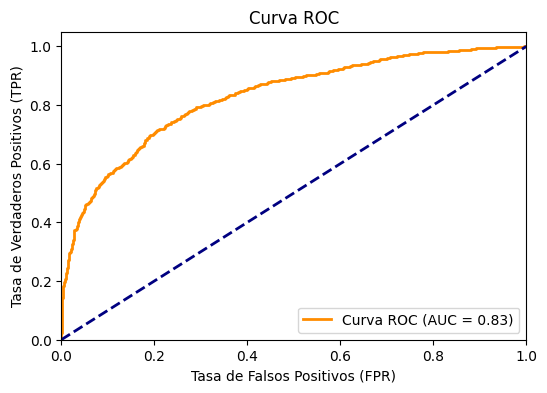

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

0.8290534056768756

El area bajo la curva ROC es 0.823 por lo que aparentemente el modelo sería bueno a la hora de discriminar entre falsos positivos y verdaderos positivos.

In [ ]:
umbrales = {'tpr': tpr, 'fpr': fpr, 'umbral':thresholds}

pd.DataFrame(umbrales)

,tpr,fpr,umbral
0,0.000000,0.000000,1.991535
1,0.001379,0.000000,0.991535
2,0.006897,0.000000,0.981531
3,0.006897,0.000433,0.979963
4,0.022069,0.000433,0.972721
...,...,...,...
811,0.998621,0.977460,0.042150
812,0.998621,0.995665,0.028519
813,1.000000,0.995665,0.027560
814,1.000000,0.999133,0.019106


## Asignar distintos pesos:

In [ ]:
# Variables explicativas:
# No incluimos RainfallTomorrow porque es evidente que los dias que 'RainfallTomorrow' > 0 entonces 'RainToday' == 1.
features = df_weather_z[['MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']]
features['RainToday'] = df_weather['RainToday']

# Variable objetivo:
target = df_weather['RainTomorrow']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [ ]:
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#### Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es 75/25
#### el error de la clase de pocos datos penaliza 3 veces más que el de la clase de muchos datos.

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      2307
           1       0.49      0.74      0.59       725

    accuracy                           0.76      3032
   macro avg       0.70      0.75      0.71      3032
weighted avg       0.81      0.76      0.77      3032

[[1757  550]
 [ 188  537]]


## SMOTE

In [ ]:
# Variables explicativas:
# No incluimos RainfallTomorrow porque es evidente que los dias que 'RainfallTomorrow' > 0 entonces 'RainToday' == 1.
features = df_weather_z[['MinTemp', 'Rainfall', 'WindSpeed9am','Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'WindDir3pm_SSW']]
features['RainToday'] = df_weather['RainToday']

# Variable objetivo:
target = df_weather['RainTomorrow']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_resampled, y_train_resampled)
y_pred = logistic_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2307
           1       0.49      0.74      0.59       725

    accuracy                           0.75      3032
   macro avg       0.70      0.75      0.71      3032
weighted avg       0.81      0.75      0.77      3032

[[1749  558]
 [ 185  540]]


No hay cambios significativos utilizando 3 metodos de balanceo. Apenas 0.01 más de recall en SMOTE y Asignar Distintos Pesos en comparación a Oversampling.
Si es cierto que el módelo balanceado marca diferencia con el no balanceado: Si bien respecto a la clase 0 no hay modificaciones importantes, en la clse 1 (cuando llueve) precision baja en 0.3 mientras que recall aumenta la misma magnitud y f1 aumenta 0.04. Por otra parte accuracy respecto del modelo completo, baja 0.06.